In [1]:
#!pip install statsmodels

In [49]:
# Importing libraries
import requests
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import time
from collections import Counter
from tqdm import tqdm
import statsmodels.api as sm
import seaborn as sns
import warnings
from scipy.stats import norm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.patches as mpatches
import pickle
from sklearn.metrics import r2_score
from matplotlib.lines import Line2D

warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)


## 1. OverView of the data

Our Datasets contains stats of players in NBA season for every year from 2010 to 2023.

We also have a rookies datasets which only shows the IDs of the rookies for a given season. A rookie is a new player who never played in The NBA, debuting in a certain season.

Our goal is to study the career of the player staring from his rookie years.

### 1.1 Import Data

All the datasets are taken from [this site](www.basketball-reference.com), using scrapers to import data in order to be able to change starting year and ending year.

So at the end of the scraped operation we will have 3 datasets: 

- *df_basic*: which contains basic statistics for every player for a given season.
- *df_advanced*: which contains more advanced statistics for every player for a given season.
- *rookies_id*: the dataset containing all the rookies for a given year.

The final dataset (called *rookies_df*) will have all the basic statistics for every rookie of his first year in NBA and some advanced statistics (in particular we will consider **PER_mean**) of the entire career.

To do that we will merge the first 2 DataFrames, importing only a few useful advanced statistics, and calculating **PER_mean** for the entire career of a player. Then we will select only the rows relative to rookies first year playing in the NBA.

In [3]:
def scraper_basic_statistics(starting_year, ending_year):
    df = pd.DataFrame()
    
    for year in tqdm(range(starting_year, ending_year + 1), desc="Processing Years", unit = "year"):
        try:
            response = requests.get(f'https://www.basketball-reference.com/leagues/NBA_{year}_per_game.html')
            
            if response.status_code == 200:
                
                soup = BeautifulSoup(response.text, 'html.parser')

                # Find the table on the page
                table = soup.find('table')

                # Read the df
                df_season = pd.read_html(str(table))[0]
                df_season = df_season.drop(columns=["Rk"])

                df_season['Season'] = year # add season
                df_season.drop_duplicates(keep = False, inplace = True) # delete headers repeated
                
                # add the id cause it has to be read from another place, it's not in the table
                td_elements = soup.find_all('td', {'data-append-csv': True})

                # Estrai i valori dell'attributo data-append-csv
                ids = [td['data-append-csv'] for td in td_elements]
                df_season['ID'] = ids
                
                # Eliminiamo le righe relative ai giocatori che hanno cambiato squadra nell'arco della stagione,
                # mantenendo solo la riga relativa alle statistiche delle 2 o più squadre in cui ha militato.
                condition = (df_season['Tm'] != 'TOT') & df_season.duplicated(subset=['Player', 'Season'], keep=False)

                # Applica le condizioni utilizzando il metodo loc
                df_season = df_season.loc[~condition]
                
                # concat
                df = pd.concat([df, df_season])
                time.sleep(1)
            
            else:
                print(f"Failed to retrieve the page. Status code: {response.status_code}")

        except requests.exceptions.RequestException as e:
            # Handle exceptions that may occur during the request
            print(f"An error occurred during the request: {e}")
    
    columns_float = ['MP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%',
                    'eFG%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS']
    
    df[columns_float] = df[columns_float].astype(float)
    
    columns_int = ['G', 'Age', 'GS']
    df[columns_int] = df[columns_int].astype(int)
    
    return df

In [4]:
def scraper_advanced_statistics(starting_year, ending_year):
    df = pd.DataFrame()
    
    for year in tqdm(range(starting_year, ending_year + 1), desc="Processing Years", unit = "year"):
        try:
            response = requests.get(f'https://www.basketball-reference.com/leagues/NBA_{year}_advanced.html')
            
            if response.status_code == 200:
                
                soup = BeautifulSoup(response.text, 'html.parser')

                # Find the table on the page
                table = soup.find('table')

                # Read the df
                df_season = pd.read_html(str(table))[0]
                df_season = df_season.drop(columns=['Unnamed: 19', "Unnamed: 24", "Rk"])
                df_season['Season'] = year # add season
                df_season.drop_duplicates(keep = False, inplace = True) # delete headers repeated
                
                # add the id cause it has to be read from another place, it's not in the table
                td_elements = soup.find_all('td', {'data-append-csv': True})

                # Estrai i valori dell'attributo data-append-csv
                ids = [td['data-append-csv'] for td in td_elements]
                df_season['ID'] = ids
                
                # Eliminiamo le righe relative ai giocatori che hanno cambiato squadra nell'arco della stagione,
                # mantenendo solo la riga relativa alle statistiche delle 2 o più squadre in cui ha militato.
                condition = (df_season['Tm'] != 'TOT') & df_season.duplicated(subset=['Player', 'Season'], keep=False)

                # Applica le condizioni utilizzando il metodo loc
                df_season = df_season.loc[~condition]
                
                # concat
                df = pd.concat([df, df_season])
                time.sleep(1)
            
            else:
                print(f"Failed to retrieve the page. Status code: {response.status_code}")

        except requests.exceptions.RequestException as e:
            # Handle exceptions that may occur during the request
            print(f"An error occurred during the request: {e}")
        
    columns_float = ['PER', 'TS%', '3PAr', 'FTr', 'ORB%', 'DRB%', 'TRB%', 'AST%', 'STL%', 'BLK%',
                    'TOV%', 'USG%', 'OWS', 'DWS', 'WS', 'WS/48', 'OBPM', 'DBPM', 'BPM', 'VORP']
    df[columns_float] = df[columns_float].astype(float)
    
    columns_int = ['G', 'Age', 'MP']
    df[columns_int] = df[columns_int].astype(int)

    return df

In [5]:
df_basic = scraper_basic_statistics(2010, 2023)
df_basic.info()

Processing Years:   0%|          | 0/14 [00:00<?, ?year/s]

Processing Years: 100%|██████████| 14/14 [00:41<00:00,  2.94s/year]

<class 'pandas.core.frame.DataFrame'>
Index: 7056 entries, 0 to 704
Data columns (total 31 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Player  7056 non-null   object 
 1   Pos     7056 non-null   object 
 2   Age     7056 non-null   int32  
 3   Tm      7056 non-null   object 
 4   G       7056 non-null   int32  
 5   GS      7056 non-null   int32  
 6   MP      7056 non-null   float64
 7   FG      7056 non-null   float64
 8   FGA     7056 non-null   float64
 9   FG%     7022 non-null   float64
 10  3P      7056 non-null   float64
 11  3PA     7056 non-null   float64
 12  3P%     6378 non-null   float64
 13  2P      7056 non-null   float64
 14  2PA     7056 non-null   float64
 15  2P%     6984 non-null   float64
 16  eFG%    7022 non-null   float64
 17  FT      7056 non-null   float64
 18  FTA     7056 non-null   float64
 19  FT%     6746 non-null   float64
 20  ORB     7056 non-null   float64
 21  DRB     7056 non-null   float64
 22  TRB   

In [6]:
df_basic.tail(20)

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Season,ID
682,Jeenathan Williams,SG,23,POR,5,4,25.4,4.8,7.8,0.615,0.6,1.6,0.375,4.2,6.2,0.677,0.654,0.4,0.6,0.667,2.0,1.0,3.0,2.0,0.6,0.4,0.8,2.6,10.6,2023,willije02
684,Kenrich Williams,PF,28,OKC,53,10,22.8,3.4,6.5,0.517,0.9,2.5,0.373,2.4,4.0,0.608,0.590,0.3,0.7,0.436,1.8,3.1,4.9,2.0,0.8,0.3,0.6,2.1,8.0,2023,willike04
685,Mark Williams,C,21,CHO,43,17,19.3,3.7,5.8,0.637,0.0,0.0,NaN,3.7,5.8,0.637,0.637,1.6,2.3,0.691,2.2,4.9,7.1,0.4,0.7,1.0,0.9,2.2,9.0,2023,willima07
686,Patrick Williams,PF,21,CHI,82,65,28.3,3.8,8.3,0.464,1.4,3.4,0.415,2.4,4.9,0.498,0.549,1.1,1.3,0.857,1.0,3.0,4.0,1.2,0.9,0.9,1.2,1.8,10.2,2023,willipa01
687,Robert Williams,C,25,BOS,35,20,23.5,3.6,4.9,0.747,0.0,0.0,0.000,3.6,4.8,0.751,0.747,0.7,1.2,0.610,3.0,5.4,8.3,1.4,0.6,1.4,1.0,1.9,8.0,2023,williro04
688,Vince Williams Jr.,SG,22,MEM,15,1,7.0,0.8,2.7,0.300,0.3,1.9,0.143,0.5,0.8,0.667,0.350,0.1,0.1,1.000,0.3,0.7,1.0,0.3,0.4,0.1,0.3,0.8,2.0,2023,willivi01
689,Ziaire Williams,SF,21,MEM,37,4,15.2,2.3,5.3,0.429,0.7,2.6,0.258,1.6,2.7,0.596,0.492,0.5,0.6,0.773,0.4,1.7,2.1,0.9,0.4,0.2,1.0,1.6,5.7,2023,willizi02
690,Zion Williamson,PF,22,NOP,29,29,33.0,9.8,16.2,0.608,0.2,0.7,0.368,9.6,15.5,0.618,0.615,6.1,8.6,0.714,2.0,5.0,7.0,4.6,1.1,0.6,3.4,2.2,26.0,2023,willizi01
691,Dylan Windler,SF,26,CLE,3,0,3.3,0.7,1.0,0.667,0.3,0.7,0.500,0.3,0.3,1.000,0.833,0.0,0.0,NaN,0.0,0.0,0.0,0.3,0.3,0.0,0.3,0.0,1.7,2023,windldy01
692,Justise Winslow,PF,26,POR,29,11,26.8,2.8,6.8,0.409,0.5,1.6,0.311,2.3,5.3,0.438,0.444,0.7,1.0,0.714,1.7,3.3,5.0,3.4,1.0,0.4,1.5,3.1,6.8,2023,winslju01


In [7]:
starting_year = 2010
ending_year = 2023

df_advanced = scraper_advanced_statistics(starting_year=starting_year, ending_year=ending_year)
df_advanced.info()

Processing Years: 100%|██████████| 14/14 [01:00<00:00,  4.30s/year]

<class 'pandas.core.frame.DataFrame'>
Index: 7056 entries, 0 to 704
Data columns (total 28 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Player  7056 non-null   object 
 1   Pos     7056 non-null   object 
 2   Age     7056 non-null   int32  
 3   Tm      7056 non-null   object 
 4   G       7056 non-null   int32  
 5   MP      7056 non-null   int32  
 6   PER     7054 non-null   float64
 7   TS%     7023 non-null   float64
 8   3PAr    7022 non-null   float64
 9   FTr     7022 non-null   float64
 10  ORB%    7054 non-null   float64
 11  DRB%    7054 non-null   float64
 12  TRB%    7054 non-null   float64
 13  AST%    7054 non-null   float64
 14  STL%    7054 non-null   float64
 15  BLK%    7054 non-null   float64
 16  TOV%    7027 non-null   float64
 17  USG%    7054 non-null   float64
 18  OWS     7056 non-null   float64
 19  DWS     7056 non-null   float64
 20  WS      7056 non-null   float64
 21  WS/48   7054 non-null   float64
 22  OBPM  

In [8]:
df_advanced[df_advanced['Player'] == "LeBron James"].tail(50)

,Player,Pos,Age,Tm,G,MP,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,Season,ID
296,LeBron James,SF,25,CLE,76,2966,31.1,0.604,0.253,0.506,3.0,18.5,11.1,41.8,2.2,2.0,12.3,33.5,13.3,5.2,18.5,0.299,9.1,2.8,11.8,10.3,2010,jamesle01
322,LeBron James,SF,26,MIA,79,3063,27.3,0.594,0.188,0.446,3.3,18.7,11.4,34.9,2.1,1.3,13.8,31.5,10.3,5.3,15.6,0.244,6.3,1.8,8.1,7.8,2011,jamesle01
280,LeBron James,SF,27,MIA,62,2326,30.7,0.605,0.127,0.429,5.0,19.7,12.6,33.6,2.6,1.7,13.3,32.0,10.0,4.5,14.5,0.298,8.2,2.7,10.9,7.6,2012,jamesle01
265,LeBron James,PF,28,MIA,76,2877,31.6,0.640,0.188,0.395,4.4,20.8,13.1,36.4,2.4,1.9,12.4,30.2,14.6,4.7,19.3,0.322,9.3,2.4,11.7,9.9,2013,jamesle01
307,LeBron James,PF,29,MIA,77,2902,29.3,0.649,0.226,0.432,3.6,18.9,11.5,32.0,2.2,0.8,14.4,31.0,12.3,3.7,15.9,0.264,7.8,1.1,8.8,7.9,2014,jamesle01
303,LeBron James,SF,30,CLE,69,2493,25.9,0.577,0.265,0.413,2.4,16.6,9.6,38.6,2.3,1.6,15.3,32.3,7.4,2.9,10.4,0.199,6.1,1.0,7.1,5.7,2015,jamesle01
276,LeBron James,SF,31,CLE,76,2709,27.5,0.588,0.199,0.347,4.7,18.8,11.8,36.0,2.0,1.5,13.2,31.4,9.6,4.0,13.6,0.242,7.0,2.0,9.0,7.5,2016,jamesle01
281,LeBron James,SF,32,CLE,74,2794,27.0,0.619,0.254,0.395,4.0,20.7,12.6,41.3,1.6,1.3,16.1,30.0,9.8,3.0,12.9,0.221,6.4,1.2,7.6,6.7,2017,jamesle01
316,LeBron James,PF,33,CLE,82,3026,28.6,0.621,0.257,0.336,3.7,22.3,13.1,44.4,1.9,2.0,16.1,31.6,11.0,3.0,14.0,0.221,7.3,1.4,8.7,8.2,2018,jamesle01
347,LeBron James,SF,34,LAL,55,1937,25.6,0.588,0.299,0.382,3.1,21.3,12.4,39.4,1.7,1.4,13.3,31.6,4.7,2.6,7.2,0.179,6.4,1.7,8.0,4.9,2019,jamesle01


In [9]:
print(df_basic.shape)
print(df_advanced.shape)

(7056, 31)
(7056, 28)


In [10]:
merged_df = pd.merge(df_basic, df_advanced[['PER', 'ID', 'Season', 'Player', 'WS', 'WS/48']], on=['ID', 'Season', 'Player'])
merged_df.sort_values(by=['ID', 'Season']).head(30)

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Season,ID,PER,WS,WS/48
3287,Álex Abrines,SG,23,OKC,68,6,15.5,2.0,5.0,0.393,1.4,3.6,0.381,0.6,1.4,0.426,0.531,0.6,0.7,0.898,0.3,1.0,1.3,0.6,0.5,0.1,0.5,1.7,6.0,2017,abrinal01,10.1,2.1,0.096
3773,Álex Abrines,SG,24,OKC,75,8,15.1,1.5,3.9,0.395,1.1,2.9,0.380,0.4,0.9,0.443,0.540,0.5,0.6,0.848,0.3,1.2,1.5,0.4,0.5,0.1,0.3,1.7,4.7,2018,abrinal01,9.0,2.2,0.094
4313,Álex Abrines,SG,25,OKC,31,2,19.0,1.8,5.1,0.357,1.3,4.1,0.323,0.5,1.0,0.500,0.487,0.4,0.4,0.923,0.2,1.4,1.5,0.6,0.5,0.2,0.5,1.7,5.3,2019,abrinal01,6.3,0.6,0.053
5372,Precious Achiuwa,PF,21,MIA,61,4,12.1,2.0,3.7,0.544,0.0,0.0,0.000,2.0,3.7,0.546,0.544,0.9,1.8,0.509,1.2,2.2,3.4,0.5,0.3,0.5,0.7,1.5,5.0,2021,achiupr01,14.2,1.3,0.085
5912,Precious Achiuwa,C,22,TOR,73,28,23.6,3.6,8.3,0.439,0.8,2.1,0.359,2.9,6.1,0.468,0.486,1.1,1.8,0.595,2.0,4.5,6.5,1.1,0.5,0.6,1.2,2.1,9.1,2022,achiupr01,12.7,2.5,0.070
6517,Precious Achiuwa,C,23,TOR,55,12,20.7,3.6,7.3,0.485,0.5,2.0,0.269,3.0,5.4,0.564,0.521,1.6,2.3,0.702,1.8,4.1,6.0,0.9,0.6,0.5,1.1,1.9,9.2,2023,achiupr01,15.2,2.2,0.093
1372,Quincy Acy,PF,22,TOR,29,0,11.8,1.4,2.6,0.560,0.0,0.1,0.500,1.4,2.5,0.562,0.567,1.1,1.3,0.816,1.0,1.6,2.7,0.4,0.4,0.5,0.6,1.8,4.0,2013,acyqu01,15.9,1.1,0.157
1839,Quincy Acy,SF,23,TOT,63,0,13.4,1.0,2.2,0.468,0.1,0.2,0.267,1.0,2.0,0.492,0.482,0.6,0.8,0.660,1.1,2.3,3.4,0.4,0.4,0.4,0.5,1.9,2.7,2014,acyqu01,10.1,1.5,0.086
2319,Quincy Acy,PF,24,NYK,68,22,18.9,2.2,4.9,0.459,0.3,0.9,0.300,2.0,4.0,0.494,0.486,1.1,1.4,0.784,1.2,3.3,4.4,1.0,0.4,0.3,0.9,2.2,5.9,2015,acyqu01,11.9,1.7,0.063
2811,Quincy Acy,PF,25,SAC,59,29,14.8,2.0,3.6,0.556,0.3,0.8,0.388,1.7,2.8,0.606,0.600,0.8,1.2,0.735,1.1,2.1,3.2,0.5,0.5,0.4,0.5,1.7,5.2,2016,acyqu01,14.7,2.5,0.137


In [11]:
def rookies_id(starting_year, ending_year):
    rookies_per_year = {}
    
    for year in tqdm(range(starting_year, ending_year + 1), desc="Processing Rookies", unit = "year"):
        try:
            response = requests.get(f'https://www.basketball-reference.com/leagues/NBA_{year}_rookies.html')
            
            if response.status_code == 200:
                
                soup = BeautifulSoup(response.text, 'html.parser')
                    
                td_elements = soup.find_all('td', {'data-append-csv': True})

                # Estrai i valori dell'attributo data-append-csv
                ids = [td['data-append-csv'] for td in td_elements]
                
                rookies_per_year[year] = ids
                time.sleep(1)
                
            else:
                print(f"Failed to retrieve the page. Status code: {response.status_code}")

        except requests.exceptions.RequestException as e:
            # Handle exceptions that may occur during the request
            print(f"An error occurred during the request: {e}")
            
    return rookies_per_year

In [12]:
rookies_id = rookies_id(starting_year=starting_year, ending_year=ending_year)

Processing Rookies: 100%|██████████| 14/14 [00:22<00:00,  1.59s/year]


Adding PER_mean columns which represents the value of PER of the entire career of a certain player in NBA.

In [13]:
merged_df['PER'] = merged_df['PER'].astype(float)

In [14]:
merged_df[merged_df['ID'] == "abrinal01"]

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Season,ID,PER,WS,WS/48
3287,Álex Abrines,SG,23,OKC,68,6,15.5,2.0,5.0,0.393,1.4,3.6,0.381,0.6,1.4,0.426,0.531,0.6,0.7,0.898,0.3,1.0,1.3,0.6,0.5,0.1,0.5,1.7,6.0,2017,abrinal01,10.1,2.1,0.096
3773,Álex Abrines,SG,24,OKC,75,8,15.1,1.5,3.9,0.395,1.1,2.9,0.380,0.4,0.9,0.443,0.540,0.5,0.6,0.848,0.3,1.2,1.5,0.4,0.5,0.1,0.3,1.7,4.7,2018,abrinal01,9.0,2.2,0.094
4313,Álex Abrines,SG,25,OKC,31,2,19.0,1.8,5.1,0.357,1.3,4.1,0.323,0.5,1.0,0.500,0.487,0.4,0.4,0.923,0.2,1.4,1.5,0.6,0.5,0.2,0.5,1.7,5.3,2019,abrinal01,6.3,0.6,0.053


In [15]:
mean_PER = merged_df.groupby('ID')['PER'].mean().round(2)
merged_df = pd.merge(merged_df, mean_PER, on='ID', how='left', suffixes=('', '_mean'))
merged_df[merged_df['ID'] == "abrinal01"].head(10)

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Season,ID,PER,WS,WS/48,PER_mean
3287,Álex Abrines,SG,23,OKC,68,6,15.5,2.0,5.0,0.393,1.4,3.6,0.381,0.6,1.4,0.426,0.531,0.6,0.7,0.898,0.3,1.0,1.3,0.6,0.5,0.1,0.5,1.7,6.0,2017,abrinal01,10.1,2.1,0.096,8.47
3773,Álex Abrines,SG,24,OKC,75,8,15.1,1.5,3.9,0.395,1.1,2.9,0.380,0.4,0.9,0.443,0.540,0.5,0.6,0.848,0.3,1.2,1.5,0.4,0.5,0.1,0.3,1.7,4.7,2018,abrinal01,9.0,2.2,0.094,8.47
4313,Álex Abrines,SG,25,OKC,31,2,19.0,1.8,5.1,0.357,1.3,4.1,0.323,0.5,1.0,0.500,0.487,0.4,0.4,0.923,0.2,1.4,1.5,0.6,0.5,0.2,0.5,1.7,5.3,2019,abrinal01,6.3,0.6,0.053,8.47


Selecting only the rows relative to rookie's year for each player.

In [16]:
rookies_id

def inverted_rookies(dic):
    inverted_rookies = {}
    for key in dic.keys():
        for id in dic[key]:
            inverted_rookies[id] = key
    return inverted_rookies

In [17]:
inv_rookies = inverted_rookies(rookies_id)
inv_rookies = pd.DataFrame(list(inv_rookies.items()), columns=['ID', 'Season'])
inv_rookies.head(10)

,ID,Season
0,anderda03,2010
1,anderan02,2010
2,pendeje02,2010
3,beaubro01,2010
4,blairde01,2010
5,brockjo01,2010
6,brownde04,2010
7,budinch01,2010
8,carrode01,2010
9,casspom01,2010


In [18]:
rookies_df = pd.merge(merged_df, inv_rookies, on=['ID', 'Season'])
rookies_df.head(30)

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Season,ID,PER,WS,WS/48,PER_mean
0,David Andersen,C,29,HOU,63,0,14.1,2.3,5.4,0.432,0.4,1.2,0.346,1.9,4.2,0.458,0.472,0.7,1.1,0.687,0.9,2.4,3.3,0.7,0.2,0.2,0.6,1.9,5.8,2010,anderda03,12.1,1.3,0.070,11.50
1,Antonio Anderson,SF,24,OKC,1,0,15.0,1.0,3.0,0.333,0.0,0.0,NaN,1.0,3.0,0.333,0.333,0.0,0.0,NaN,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,2.0,2010,anderan02,-1.7,0.0,-0.104,-1.70
2,Jeff Ayres,C,22,POR,39,4,10.4,1.1,1.7,0.662,0.0,0.0,NaN,1.1,1.7,0.662,0.662,0.5,0.5,0.900,0.6,1.9,2.5,0.0,0.2,0.4,0.3,1.9,2.7,2010,pendeje02,12.1,1.3,0.156,12.30
3,Rodrigue Beaubois,PG,21,DAL,56,16,12.5,2.8,5.3,0.518,0.8,2.0,0.409,2.0,3.4,0.582,0.594,0.8,0.9,0.808,0.2,1.2,1.4,1.3,0.5,0.2,1.0,1.5,7.1,2010,beaubro01,18.5,2.0,0.134,13.95
4,DeJuan Blair,PF,20,SAS,82,23,18.2,3.4,6.0,0.556,0.0,0.0,0.000,3.4,6.0,0.558,0.556,1.1,2.0,0.547,2.4,4.0,6.4,0.8,0.6,0.5,1.4,2.7,7.8,2010,blairde01,17.7,4.6,0.147,13.91
5,Jon Brockman,PF,22,SAC,52,4,12.6,1.1,2.0,0.534,0.0,0.0,NaN,1.1,2.0,0.534,0.534,0.7,1.2,0.597,2.0,2.1,4.1,0.4,0.3,0.1,0.4,2.2,2.8,2010,brockjo01,12.4,1.7,0.125,9.53
6,Derrick Brown,SF,22,CHA,57,0,9.4,1.2,2.6,0.463,0.0,0.1,0.286,1.2,2.5,0.471,0.469,0.8,1.3,0.667,0.5,0.8,1.4,0.3,0.4,0.2,0.3,0.9,3.3,2010,brownde04,12.6,1.3,0.114,13.40
7,Chase Budinger,SF,21,HOU,74,4,20.1,3.4,7.6,0.441,1.2,3.4,0.369,2.1,4.3,0.497,0.522,0.9,1.2,0.770,0.5,2.5,3.0,1.2,0.5,0.1,0.6,1.1,8.9,2010,budinch01,14.1,3.1,0.100,12.63
8,DeMarre Carroll,SF,23,MEM,71,1,11.2,1.2,3.1,0.396,0.0,0.1,0.000,1.2,3.0,0.407,0.396,0.5,0.7,0.623,0.7,1.4,2.1,0.5,0.4,0.1,0.3,1.5,2.9,2010,carrode01,8.5,0.5,0.031,12.08
9,Omri Casspi,SF,21,SAC,77,31,25.1,3.9,8.7,0.446,1.0,2.6,0.369,2.9,6.1,0.480,0.502,1.5,2.3,0.672,1.0,3.6,4.5,1.2,0.7,0.2,1.3,1.6,10.3,2010,casspom01,13.0,2.5,0.063,13.12


In [19]:
# to load df in kernel
file_path = 'rookie_df.pkl'

# Save the data to a file
with open(file_path, 'wb') as file:
    pickle.dump(rookies_df, file)

In [20]:
with open('rookie_df.pkl', 'rb') as file:
    rookies_df= pickle.load(file)

### 1.2 Features

In [21]:
rookies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1250 entries, 0 to 1249
Data columns (total 35 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Player    1250 non-null   object 
 1   Pos       1250 non-null   object 
 2   Age       1250 non-null   int32  
 3   Tm        1250 non-null   object 
 4   G         1250 non-null   int32  
 5   GS        1250 non-null   int32  
 6   MP        1250 non-null   float64
 7   FG        1250 non-null   float64
 8   FGA       1250 non-null   float64
 9   FG%       1229 non-null   float64
 10  3P        1250 non-null   float64
 11  3PA       1250 non-null   float64
 12  3P%       1080 non-null   float64
 13  2P        1250 non-null   float64
 14  2PA       1250 non-null   float64
 15  2P%       1211 non-null   float64
 16  eFG%      1229 non-null   float64
 17  FT        1250 non-null   float64
 18  FTA       1250 non-null   float64
 19  FT%       1104 non-null   float64
 20  ORB       1250 non-null   floa

For every year for both rookies and players, here are the features in the dataset:

- **Player**: Name of the player.
- **Pos**: Position of the player.
- **Age**: Age during their rookie year.
- **Tm**: Rookie's team during his first year.
- **G**: Number of games played.
- **MP**: Minutes played per game.
- **FG, FGA**: Field goals made and attempted.
- **3P, 3PA**: Three-point field goals made and attempted.
- **2P, 2PA**: Two-point field goals made and attempted.
- **FT, FTA**: Free throws made and attempted.
- **TRB**: Total rebounds.
- **DRB**: Defensive rebounds.
- **ORB**: Offensive rebounds.
- **AST**: Assists.
- **STL**: Steals.
- **BLK**: Blocks.
- **PF**: Personal fouls.
- **PTS**: Points per game.
- **FG%**, **3P%**,**2P%**, **FT%**, **eFG%**: Shooting percentages.
- **ID**: Unique identifier for the player.
- **Season**: Season Played.
- **PER**: Player Efficiency Rating for the first NBA year. A statistical measure which attempts to collect or boil down all of a player's contributions into one number.
- **PER_mean**: Player Efficiency Rating for the entire career of a player.

### 1.3 Organize our  data

We can get players or rookies from a particular year.

In [22]:
def get_players_data(year, player_id = "all"):
    """
    Return the dataset of a particular year for all players or a specific one.
    """
    if player_id == "all":
        return merged_df[merged_df['Season'] == year]
    
    else:
        return merged_df[(merged_df['Season'] == year) & (merged_df['ID'] == player_id)]

def get_rookies_data_at_draft(year):
    """
    Return the dataset of a particular year for  only rookies drafted that year
    """
    return rookies_df[rookies_df['Season'] == year]


def get_all_rookies_ids(start_year, end_year):
    rookies_ids = []
    for year in range(start_year, end_year):
        if year != 2016:
            ids = get_rookies_data_at_draft['ID'].tolist()
            rookies_ids.extend(ids)
    return list(set(rookies_ids))

In [23]:
players_2014 = get_players_data(2014, 'acyqu01')
players_2014.head(5)

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Season,ID,PER,WS,WS/48,PER_mean
1839,Quincy Acy,SF,23,TOT,63,0,13.4,1.0,2.2,0.468,0.1,0.2,0.267,1.0,2.0,0.492,0.482,0.6,0.8,0.66,1.1,2.3,3.4,0.4,0.4,0.4,0.5,1.9,2.7,2014,acyqu01,10.1,1.5,0.086,10.79


## 2. Data Preprocessing

### 2.1 Standadize Player roles

Cleaning positions, considering only the most important of them.

In [24]:
Counter(rookies_df['Pos'].tolist())

Counter({'SG': 336,
         'PG': 249,
         'PF': 245,
         'SF': 231,
         'C': 183,
         'SG-SF': 2,
         'PF-SF': 1,
         'C-PF': 1,
         'SF-SG': 1,
         'SG-PG': 1})

In [25]:
#Defining a custom function to standardize roles
def standadize_role(role):
    roles = {
        "SG-SF": "SG",
        "SF-SG": "SF",
        "SG-PG": "SG",
        "PF-SF": "PF",
        "C-PF": "C",
        "SF-PF": "SF",
        "PF-C": "PF"

    }
    return roles.get(role, role)

In [26]:
rookies_df['Pos'] = rookies_df['Pos'].apply(standadize_role)
Counter(rookies_df['Pos'].tolist())

Counter({'SG': 339, 'PG': 249, 'PF': 246, 'SF': 232, 'C': 184})

In [27]:
rookies_df.head(3)

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Season,ID,PER,WS,WS/48,PER_mean
0,David Andersen,C,29,HOU,63,0,14.1,2.3,5.4,0.432,0.4,1.2,0.346,1.9,4.2,0.458,0.472,0.7,1.1,0.687,0.9,2.4,3.3,0.7,0.2,0.2,0.6,1.9,5.8,2010,anderda03,12.1,1.3,0.070,11.5
1,Antonio Anderson,SF,24,OKC,1,0,15.0,1.0,3.0,0.333,0.0,0.0,NaN,1.0,3.0,0.333,0.333,0.0,0.0,NaN,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,2.0,2010,anderan02,-1.7,0.0,-0.104,-1.7
2,Jeff Ayres,C,22,POR,39,4,10.4,1.1,1.7,0.662,0.0,0.0,NaN,1.1,1.7,0.662,0.662,0.5,0.5,0.900,0.6,1.9,2.5,0.0,0.2,0.4,0.3,1.9,2.7,2010,pendeje02,12.1,1.3,0.156,12.3


<Axes: ylabel='PER_mean'>

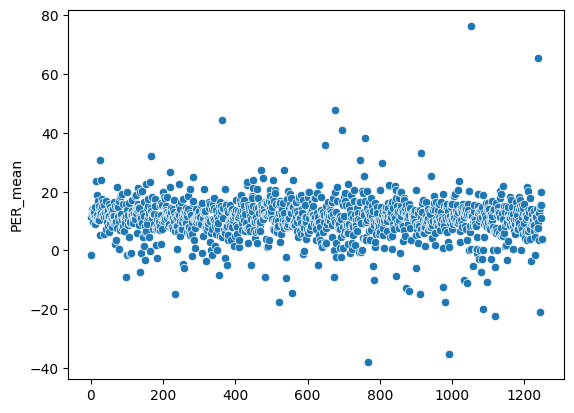

In [28]:
sns.scatterplot(rookies_df["PER_mean"])

We will remove players who played a very low number of games (<10), those who have a PER_mean above 40 and player with a PER_mean below 0

In [29]:
rookies_df=rookies_df[rookies_df["PER_mean"]>=0 | (rookies_df["Season"]==2023)]
rookies_df=rookies_df[(rookies_df["G"] > 10) | (rookies_df["Season"]==2023)]
rookies_df=rookies_df[(rookies_df["PER_mean"] <40)]

<Axes: ylabel='PER_mean'>

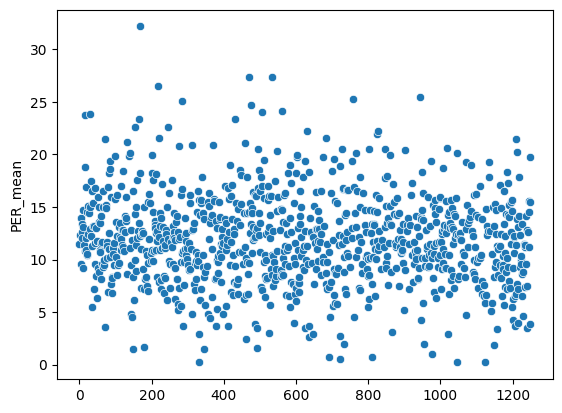

In [30]:
sns.scatterplot(rookies_df["PER_mean"])

In [32]:
rookies_df.describe().round(2) # 955 players remaining

,Age,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Season,PER,WS,WS/48,PER_mean
count,955.00,955.00,955.00,955.00,955.00,955.00,955.00,955.00,955.00,872.00,955.00,955.00,953.00,955.00,955.00,955.00,942.00,955.00,955.00,955.00,955.00,955.00,955.00,955.00,955.00,955.00,955.00,955.00,955.00,955.00,955.00
mean,22.01,43.43,12.66,15.23,2.12,4.88,0.43,0.51,1.56,0.29,1.61,3.32,0.48,0.48,0.87,1.22,0.71,0.69,1.89,2.58,1.25,0.48,0.31,0.85,1.45,5.61,2016.98,11.18,0.96,0.05,11.89
std,2.21,22.42,20.18,7.80,1.45,3.18,0.08,0.51,1.40,0.12,1.24,2.46,0.10,0.08,0.78,1.04,0.15,0.60,1.22,1.70,1.27,0.34,0.33,0.65,0.74,3.86,3.98,4.13,1.40,0.07,4.34
min,19.00,1.00,0.00,2.00,0.10,0.50,0.15,0.00,0.00,0.00,0.00,0.00,0.00,0.15,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.30,2010.00,-0.90,-2.10,-0.22,0.20
25%,20.00,23.00,0.00,9.20,1.10,2.60,0.38,0.10,0.50,0.25,0.75,1.60,0.42,0.43,0.40,0.50,0.63,0.30,1.00,1.30,0.50,0.30,0.10,0.40,0.90,2.90,2014.00,8.50,0.10,0.01,9.20
50%,22.00,42.00,2.00,13.90,1.70,4.00,0.42,0.40,1.30,0.31,1.20,2.70,0.48,0.48,0.70,0.90,0.73,0.50,1.60,2.20,0.80,0.40,0.20,0.70,1.40,4.60,2017.00,11.00,0.50,0.05,11.69
75%,23.00,63.00,16.00,20.10,2.80,6.30,0.47,0.80,2.30,0.36,2.10,4.30,0.54,0.53,1.10,1.60,0.80,0.90,2.50,3.40,1.60,0.60,0.40,1.10,1.95,7.40,2020.00,13.70,1.40,0.10,14.38
max,35.00,82.00,82.00,41.00,8.80,17.20,0.73,3.00,7.90,1.00,8.50,16.50,1.00,0.77,6.20,8.50,1.00,3.40,8.80,12.10,8.30,3.00,2.50,4.00,5.00,22.50,2023.00,27.70,9.80,0.32,32.18


## 3. Data Analysis

#### Histograms of Points, Rebounds and Assists per game

In [33]:
def plot(df):
    # Set the aesthetic style of the plots
    sns.set_style("whitegrid")

    # Create a figure with multiple subplots
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))

    # Points per game distribution
    sns.histplot(df['PTS'], kde=True, ax=axes[0, 0], bins=30, color='skyblue')
    axes[0, 0].set_title('Distribution of Points per Game')

    # Rebounds per game distribution
    sns.histplot(df['TRB'], kde=True, ax=axes[0, 1], bins=30, color='lightgreen')
    axes[0, 1].set_title('Distribution of Rebounds per Game')

    # Assists per game distribution
    sns.histplot(df['AST'], kde=True, ax=axes[0, 2], bins=30, color='salmon')
    axes[0, 2].set_title('Distribution of Assists per Game')

    # Scatter plot of Points vs Rebounds
    sns.scatterplot(x='PTS', y='TRB', data=df, ax=axes[1, 0], color='purple')
    axes[1, 0].set_title('Points vs Rebounds')

    # Scatter plot of Points vs Assists
    sns.scatterplot(x='PTS', y='AST', data=df, ax=axes[1, 1], color='orange')
    axes[1, 1].set_title('Points vs Assists')

    # Correlation heatmap
    corr = df[['PTS', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF']].corr()
    sns.heatmap(corr, annot=True, cmap='coolwarm', ax=axes[1, 2])
    axes[1, 2].set_title('Correlation Heatmap')

    plt.tight_layout()
    plt.show()

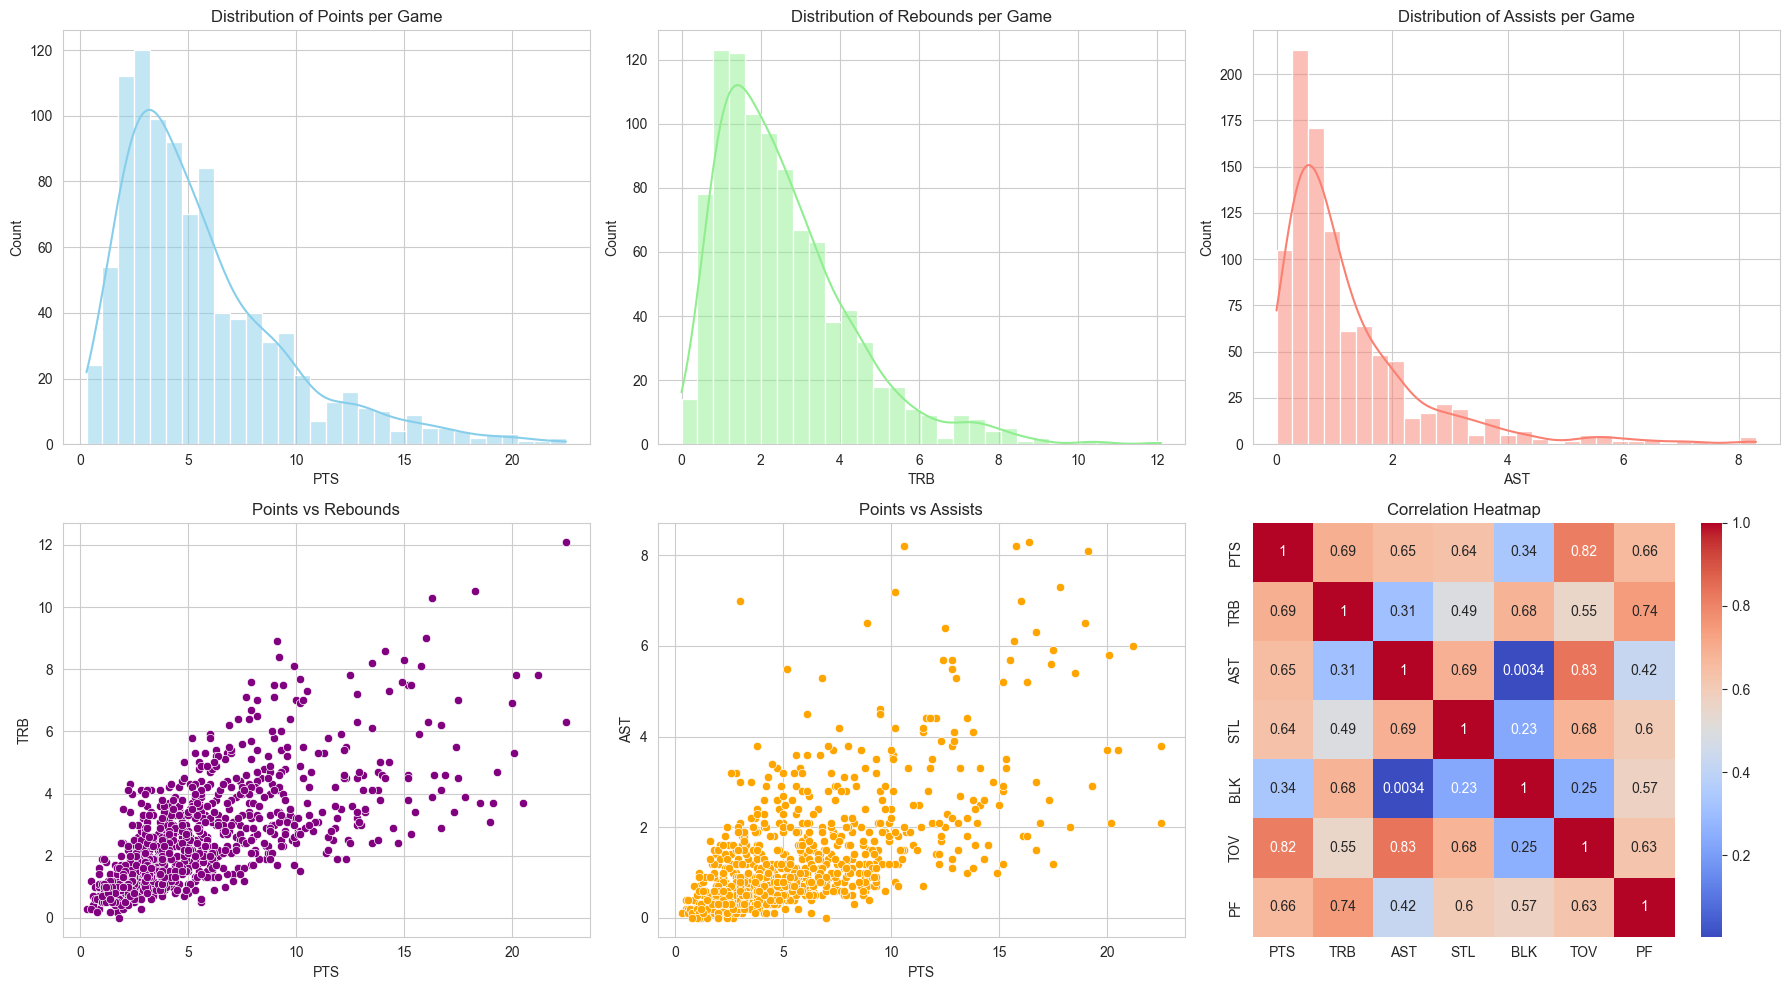

In [34]:
plot(rookies_df)

##### Histogram Observations:





**Points Per Game (PTS)**: The distribution is right-skewed, meaning most players score below the average, with a few high-scoring outliers.


**Assists Per Game (AST)**: Similar to points, the distribution is right-skewed, with most players recording fewer assists.

**Rebounds Per Game (TRB)**: This distribution also shows a right skew, with fewer players having high rebound numbers.


**Steals Per Game (STL)**: Steals are relatively rare events, and the distribution reflects this with most players having low steal numbers.

### 3.2 Correlation Matrix

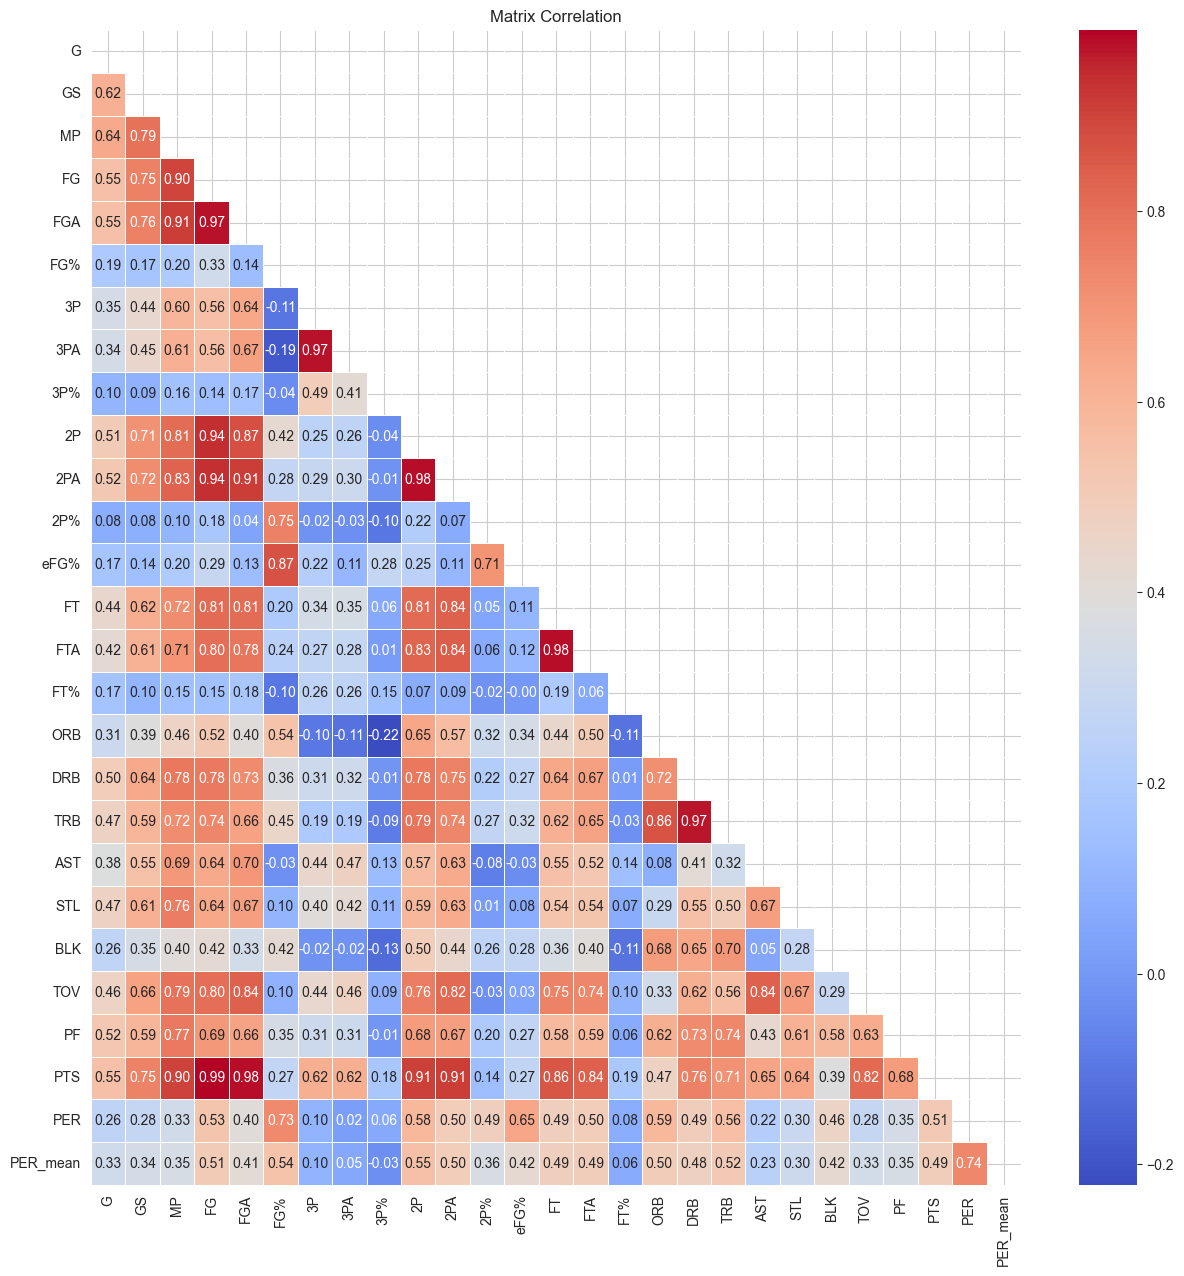

In [35]:
columns_of_interest = ['G', 'GS', 'MP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%',
                        'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'PER', 'PER_mean']

subset_df = rookies_df.dropna()[columns_of_interest]

# Calcolo della matrice di correlazione
correlation_matrix = subset_df.corr()

# Creazione di una matrice con la stessa forma di quella di correlazione ma con valori NaN
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Creazione di un heatmap per visualizzare solo la metà superiore della matrice di correlazione
plt.figure(figsize=(15, 15))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, mask=mask)
plt.title("Matrix Correlation")
plt.show()

**Strong Correlations with Points (PTS)**:
Field goals (FG), field goal attempts (FGA), minutes played (MP), and free throws (FT) show strong positive correlations with points scored. This suggests that players who have more playing time and shooting opportunities tend to score more.


**Other Notable Correlations**: Assists (AST), rebounds (TRB), and steals (STL) also correlate positively with points, indicating that players who contribute significantly in these areas often score higher points.

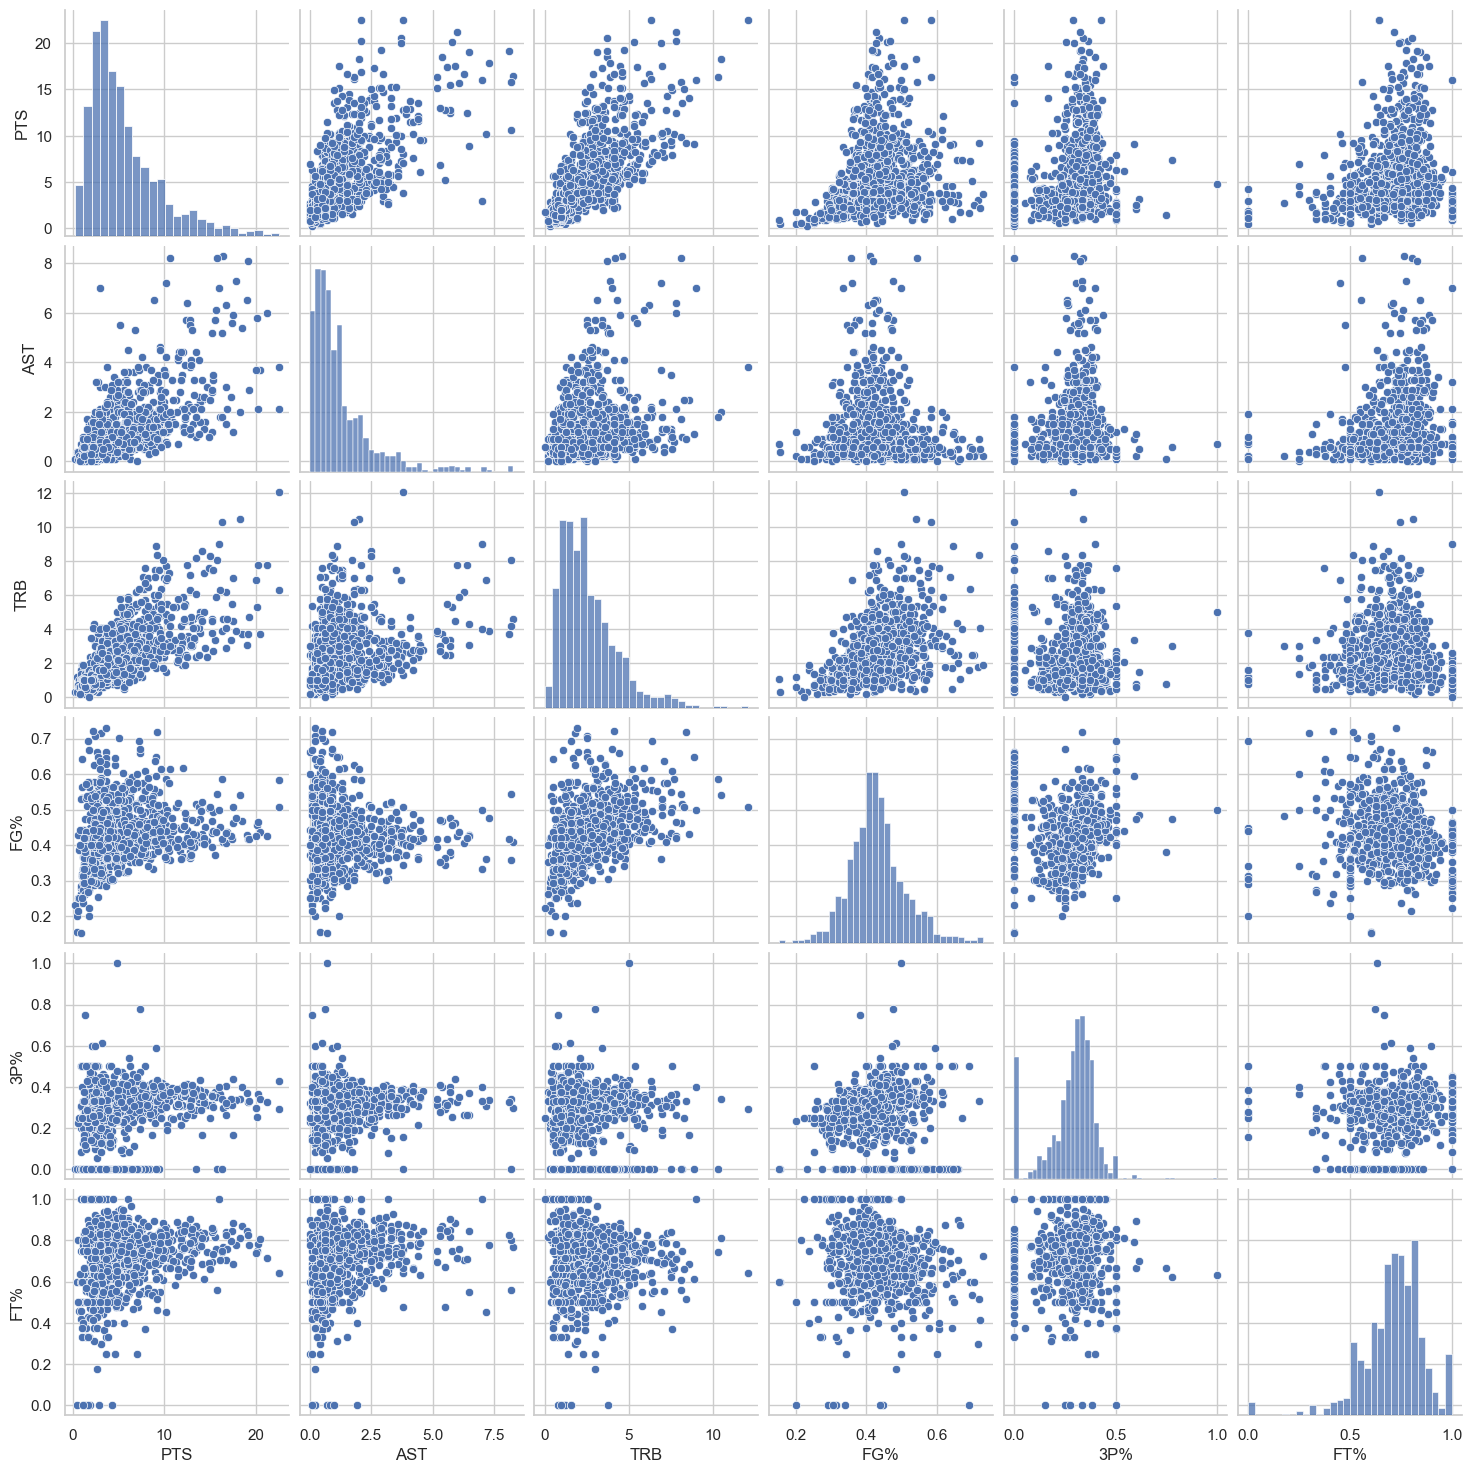

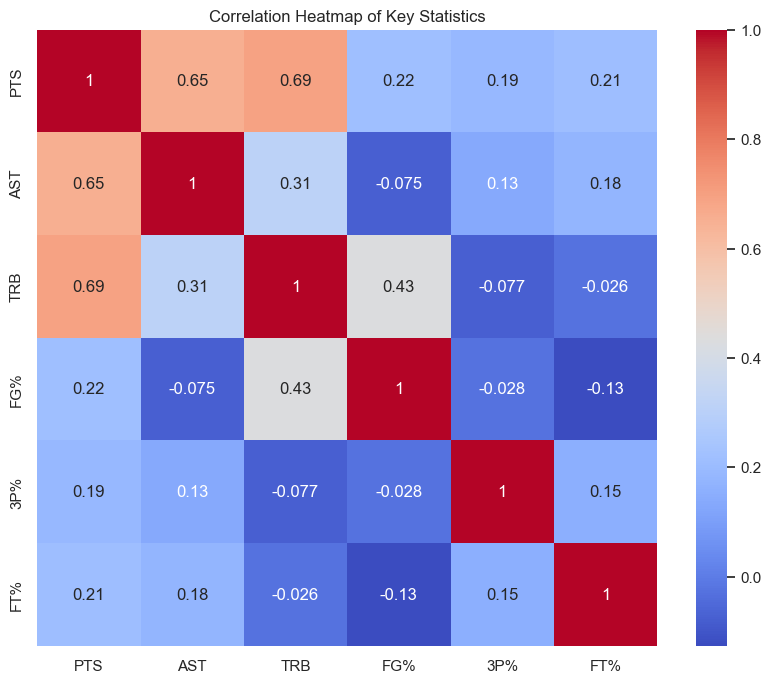

In [36]:
# Setting up the visualisation style
sns.set(style="whitegrid")

# Selecting a few key statistics for exploration
key_stats = ['PTS', 'AST', 'TRB', 'FG%', '3P%', 'FT%']

# Pairplot to visualize relationships between key stats
pairplot_data = rookies_df[key_stats]
sns.pairplot(pairplot_data)
plt.show()

# Correlation heatmap
corr = pairplot_data.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap of Key Statistics")
plt.show()

### 3.2 A glance for each year.

Let's compare rookie player's stats for every year

In [37]:
rkdf = rookies_df.copy()
pldf = df_advanced.copy()

In [38]:
# Set a custom color palette for each year
palette = sns.color_palette("husl", n_colors=len(range(2010, 2024)))

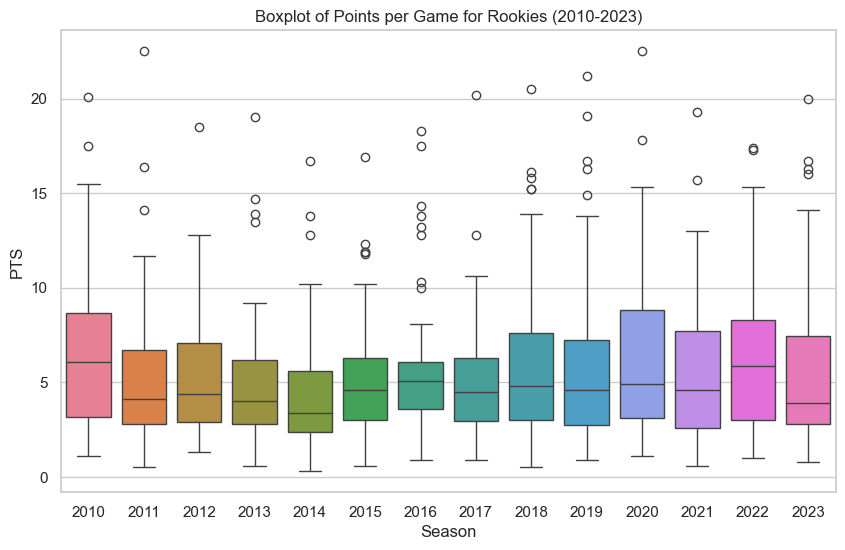

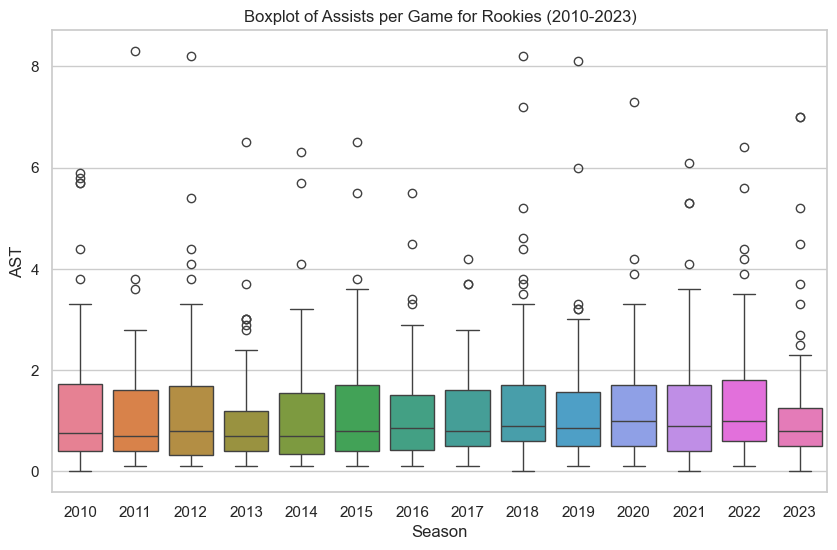

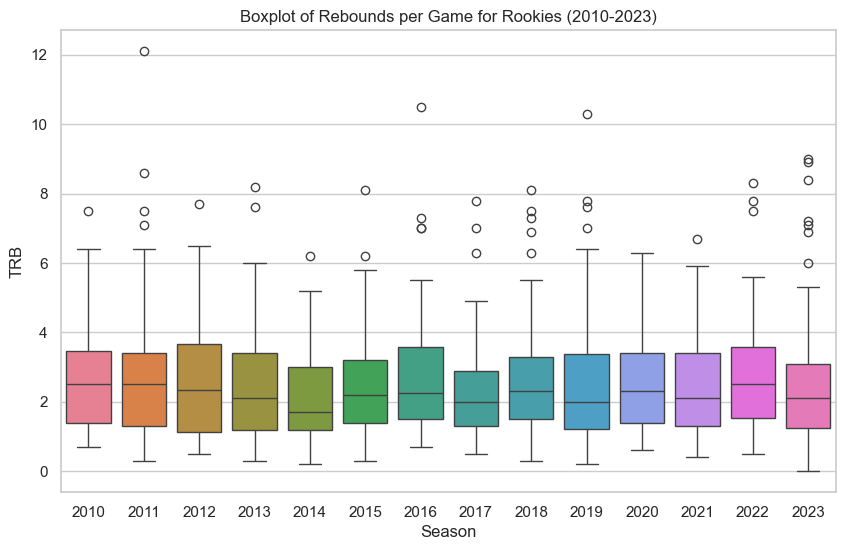

In [39]:
# Set a custom color palette for each year
palette = sns.color_palette("husl", n_colors=len(range(2010, 2024)))

# POINTS
plt.figure(figsize=(10, 6))
sns.boxplot(x='Season', y='PTS', data=rookies_df, palette=palette)
plt.title('Boxplot of Points per Game for Rookies (2010-2023)')
plt.show()

# ASSISTS
plt.figure(figsize=(10, 6))
sns.boxplot(x='Season', y='AST', data=rookies_df, palette=palette)
plt.title('Boxplot of Assists per Game for Rookies (2010-2023)')
plt.show()

# REBOUNDS
plt.figure(figsize=(10, 6))
sns.boxplot(x='Season', y='TRB', data=rookies_df, palette=palette)
plt.title('Boxplot of Rebounds per Game for Rookies (2010-2023)')
plt.show()


### 3.3 Graphs

Now let's compare rookies progress along the career years, making a distinction by position.

In [40]:
# Assuming 'id' is the common column between the two dataframes
aux_df = pd.merge(merged_df, inv_rookies.rename(columns={'Season': 'Debut'}), on='ID')
# Calculate career year
aux_df['Career_Year'] = aux_df['Season'] - aux_df['Season'].min() + 1

# adjust the positions
aux_df['Pos'] = aux_df['Pos'].apply(standadize_role)

In [41]:
# it contains all the season stats 
# of the players that have been a rookie 
# between 2010 and 2023
aux_df.head() 

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Season,ID,PER,WS,WS/48,PER_mean,Debut,Career_Year
0,David Andersen,C,29,HOU,63,0,14.1,2.3,5.4,0.432,0.4,1.2,0.346,1.9,4.2,0.458,0.472,0.7,1.1,0.687,0.9,2.4,3.3,0.7,0.2,0.2,0.6,1.9,5.8,2010,anderda03,12.1,1.3,0.070,11.5,2010,1
1,David Andersen,PF,30,TOT,40,0,9.3,1.4,3.0,0.463,0.2,0.6,0.348,1.2,2.5,0.490,0.496,0.4,0.6,0.636,0.5,1.6,2.1,0.3,0.1,0.2,0.6,1.0,3.4,2011,anderda03,10.9,0.3,0.032,11.5,2010,2
2,Antonio Anderson,SF,24,OKC,1,0,15.0,1.0,3.0,0.333,0.0,0.0,NaN,1.0,3.0,0.333,0.333,0.0,0.0,NaN,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,2.0,2010,anderan02,-1.7,0.0,-0.104,-1.7,2010,1
3,Jeff Ayres,C,22,POR,39,4,10.4,1.1,1.7,0.662,0.0,0.0,NaN,1.1,1.7,0.662,0.662,0.5,0.5,0.900,0.6,1.9,2.5,0.0,0.2,0.4,0.3,1.9,2.7,2010,pendeje02,12.1,1.3,0.156,12.3,2010,1
4,Jeff Ayres,C,24,IND,20,1,5.3,0.8,1.8,0.417,0.0,0.0,NaN,0.8,1.8,0.417,0.417,0.2,0.4,0.571,0.6,1.1,1.7,0.2,0.2,0.1,0.1,0.8,1.7,2012,pendeje02,13.4,0.3,0.115,12.3,2010,3


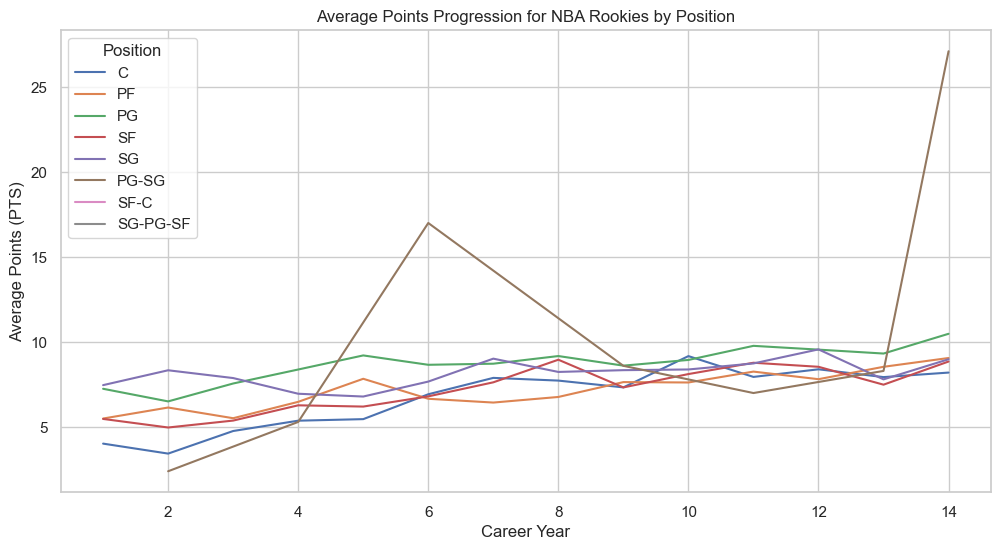

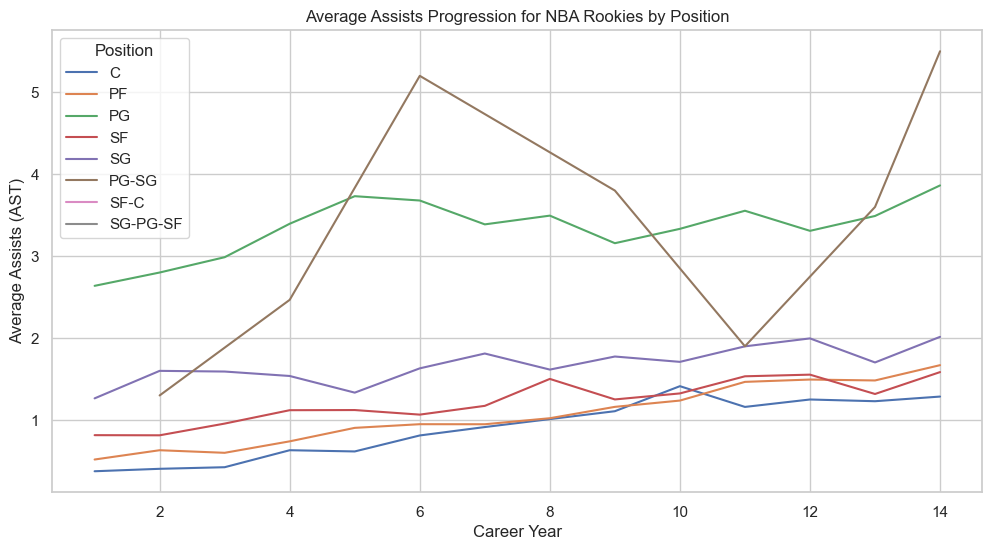

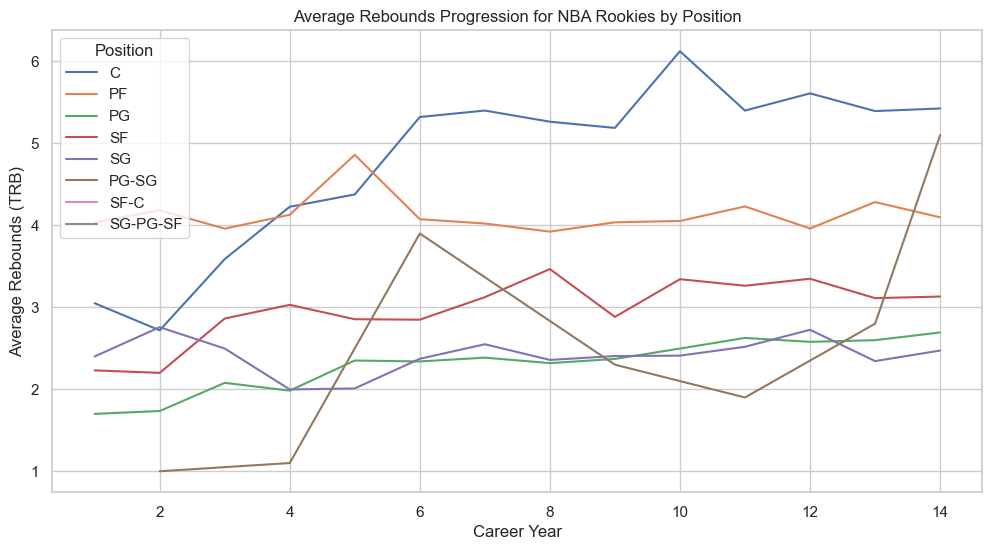

In [42]:
# Calculate average points for each career year and position
avg_points = aux_df.groupby(['Career_Year', 'Pos'])['PTS'].mean().reset_index()
avg_assists = aux_df.groupby(['Career_Year', 'Pos'])['AST'].mean().reset_index()
avg_rebounds = aux_df.groupby(['Career_Year', 'Pos'])['TRB'].mean().reset_index()

# Create a line plot for each position
plt.figure(figsize=(12, 6))
sns.lineplot(x='Career_Year', y='PTS', hue='Pos', data=avg_points)
plt.title('Average Points Progression for NBA Rookies by Position')
plt.xlabel('Career Year')
plt.ylabel('Average Points (PTS)')
plt.legend(title='Position')
plt.show()

# Create a line plot for each position
plt.figure(figsize=(12, 6))
sns.lineplot(x='Career_Year', y='AST', hue='Pos', data=avg_assists)
plt.title('Average Assists Progression for NBA Rookies by Position')
plt.xlabel('Career Year')
plt.ylabel('Average Assists (AST)')
plt.legend(title='Position')
plt.show()

# Create a line plot for each position
plt.figure(figsize=(12, 6))
sns.lineplot(x='Career_Year', y='TRB', hue='Pos', data=avg_rebounds)
plt.title('Average Rebounds Progression for NBA Rookies by Position')
plt.xlabel('Career Year')
plt.ylabel('Average Rebounds (TRB)')
plt.legend(title='Position')
plt.show()

## 4. Regression

In [43]:
rookies_df.head()

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Season,ID,PER,WS,WS/48,PER_mean
0,David Andersen,C,29,HOU,63,0,14.1,2.3,5.4,0.432,0.4,1.2,0.346,1.9,4.2,0.458,0.472,0.7,1.1,0.687,0.9,2.4,3.3,0.7,0.2,0.2,0.6,1.9,5.8,2010,anderda03,12.1,1.3,0.070,11.50
2,Jeff Ayres,C,22,POR,39,4,10.4,1.1,1.7,0.662,0.0,0.0,NaN,1.1,1.7,0.662,0.662,0.5,0.5,0.900,0.6,1.9,2.5,0.0,0.2,0.4,0.3,1.9,2.7,2010,pendeje02,12.1,1.3,0.156,12.30
3,Rodrigue Beaubois,PG,21,DAL,56,16,12.5,2.8,5.3,0.518,0.8,2.0,0.409,2.0,3.4,0.582,0.594,0.8,0.9,0.808,0.2,1.2,1.4,1.3,0.5,0.2,1.0,1.5,7.1,2010,beaubro01,18.5,2.0,0.134,13.95
4,DeJuan Blair,PF,20,SAS,82,23,18.2,3.4,6.0,0.556,0.0,0.0,0.000,3.4,6.0,0.558,0.556,1.1,2.0,0.547,2.4,4.0,6.4,0.8,0.6,0.5,1.4,2.7,7.8,2010,blairde01,17.7,4.6,0.147,13.91
5,Jon Brockman,PF,22,SAC,52,4,12.6,1.1,2.0,0.534,0.0,0.0,NaN,1.1,2.0,0.534,0.534,0.7,1.2,0.597,2.0,2.1,4.1,0.4,0.3,0.1,0.4,2.2,2.8,2010,brockjo01,12.4,1.7,0.125,9.53


In [44]:
rookies_2023_df = rookies_df[rookies_df['Season'] == 2023]
rookies_df = rookies_df[rookies_df['Season'] != 2023]

In [45]:
rookies_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 876 entries, 0 to 1164
Data columns (total 35 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Player    876 non-null    object 
 1   Pos       876 non-null    object 
 2   Age       876 non-null    int32  
 3   Tm        876 non-null    object 
 4   G         876 non-null    int32  
 5   GS        876 non-null    int32  
 6   MP        876 non-null    float64
 7   FG        876 non-null    float64
 8   FGA       876 non-null    float64
 9   FG%       876 non-null    float64
 10  3P        876 non-null    float64
 11  3PA       876 non-null    float64
 12  3P%       796 non-null    float64
 13  2P        876 non-null    float64
 14  2PA       876 non-null    float64
 15  2P%       876 non-null    float64
 16  eFG%      876 non-null    float64
 17  FT        876 non-null    float64
 18  FTA       876 non-null    float64
 19  FT%       868 non-null    float64
 20  ORB       876 non-null    float64
 2

In [46]:
rookies_2023_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 79 entries, 1165 to 1249
Data columns (total 35 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Player    79 non-null     object 
 1   Pos       79 non-null     object 
 2   Age       79 non-null     int32  
 3   Tm        79 non-null     object 
 4   G         79 non-null     int32  
 5   GS        79 non-null     int32  
 6   MP        79 non-null     float64
 7   FG        79 non-null     float64
 8   FGA       79 non-null     float64
 9   FG%       79 non-null     float64
 10  3P        79 non-null     float64
 11  3PA       79 non-null     float64
 12  3P%       76 non-null     float64
 13  2P        79 non-null     float64
 14  2PA       79 non-null     float64
 15  2P%       77 non-null     float64
 16  eFG%      79 non-null     float64
 17  FT        79 non-null     float64
 18  FTA       79 non-null     float64
 19  FT%       74 non-null     float64
 20  ORB       79 non-null     float64


In [47]:
rookies_df=rookies_df.dropna()
rookies_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 789 entries, 0 to 1164
Data columns (total 35 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Player    789 non-null    object 
 1   Pos       789 non-null    object 
 2   Age       789 non-null    int32  
 3   Tm        789 non-null    object 
 4   G         789 non-null    int32  
 5   GS        789 non-null    int32  
 6   MP        789 non-null    float64
 7   FG        789 non-null    float64
 8   FGA       789 non-null    float64
 9   FG%       789 non-null    float64
 10  3P        789 non-null    float64
 11  3PA       789 non-null    float64
 12  3P%       789 non-null    float64
 13  2P        789 non-null    float64
 14  2PA       789 non-null    float64
 15  2P%       789 non-null    float64
 16  eFG%      789 non-null    float64
 17  FT        789 non-null    float64
 18  FTA       789 non-null    float64
 19  FT%       789 non-null    float64
 20  ORB       789 non-null    float64
 2

Here we perform a 80-20 split of the players from 2010 till 2022:

1. We are going to use 80% of our players to train our OLS model, then check summary
2. We are going to use 20% of our players to test our OLS model, then use metrics like R^2 to evaluate performance
3. If our model is good we are going to use the rookie's stats from 2023 and try to predict their career PER_mean.

In [48]:
# Randomly select a portion of players for the training set, random_state for reproducibility
train_players, test_players = train_test_split(rookies_df, test_size=0.2, random_state=42)

# Extract features (X) and target variable (y) using the specified indexes
# Train
train_x=train_players.drop(columns = ["Player","Pos","Tm","Season","ID","WS","PER_mean"])  # Features
train_y = train_players['PER_mean']  # Target variable

# Test
test_x = test_players.drop(columns = ["Player","Pos","Tm","Season","ID","WS","PER_mean"])  # Features
test_y = test_players['PER_mean']  # Target variable

# Print shape 
print("Shapes:")
print("train_x:", train_x.shape)
print("train_y:", train_y.shape)
print("test_x:", test_x.shape)
print("test_y:", test_y.shape)

Shapes:
train_x: (631, 28)
train_y: (631,)
test_x: (158, 28)
test_y: (158,)


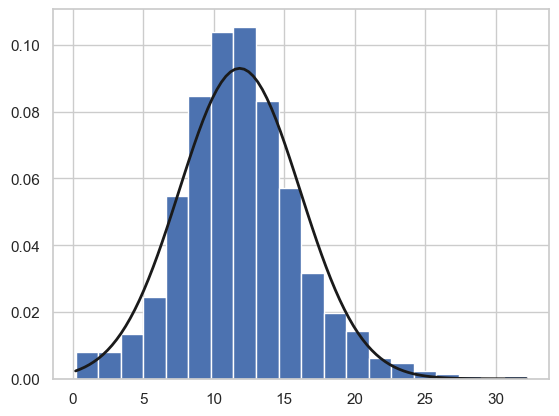

In [50]:
Y=rookies_df["PER_mean"] # predicted variable
Y.hist(bins=20, density = True)

mu, std = Y.mean(), Y.std()

# Creare un array di valori x per la curva gaussiana
x = np.linspace(Y.min(), Y.max(), 100)
p = norm.pdf(x, mu, std)

# Disegnare la curva gaussiana
plt.plot(x, p, 'k', linewidth=2)
plt.show()


* The distribution of PER_mean for all the past players from 2012 to 2022 looks like a Gaussian distribution

In [51]:
train_x=sm.add_constant(train_x)
train_x=train_x.reset_index(drop=True)
train_y=train_y.reset_index(drop=True)

In [52]:
len(train_y),len(train_x)

(631, 631)

In [53]:
# Train our model
reg=sm.OLS(train_y,train_x).fit()
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:               PER_mean   R-squared:                       0.600
Model:                            OLS   Adj. R-squared:                  0.582
Method:                 Least Squares   F-statistic:                     32.28
Date:                Sun, 17 Dec 2023   Prob (F-statistic):          6.99e-101
Time:                        12:49:33   Log-Likelihood:                -1540.2
No. Observations:                 631   AIC:                             3138.
Df Residuals:                     602   BIC:                             3267.
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         10.2870      2.326      4.422      0.0

Some considerations:

1. Model Statistics:
- **R-squared**: 0.482 - This is the proportion of the variance in the dependent variable (PER_mean) that is predictable from the independent variables. In this case, the model explains 48.2% of the variability in PER_mean.
- -**Adj. R-squared** : 0.461 - It's similar to R-squared but penalizes the inclusion of irrelevant variables. It's slightly lower than R-squared here.
2. Coefficients:
- Each coefficient represents the change in the dependent variable (PER_mean) for a one-unit change in the corresponding independent variable, holding other variables constant.
- Age: For example this coefficient (-0.28), suggests that for every one-year increase in age, PER_mean decreases by approximately 0.28.
- 3P: For example this coefficient (2.7515 ), suggests that for every additional three-point field goal (3P) made in a rookie season, the model predicts an increase of approximately 2.7515 units in PER_mean.
3. Significance of Coefficients:
- The P>|t| values indicate the probability that each coefficient is not equal to zero. Smaller p-values suggest that the corresponding variable is significant.
- For example, Age has a very small p-value (0.055), indicating that it is likely a significant predictor of PER_mean.


Text(0, 0.5, 'Predicted PER')

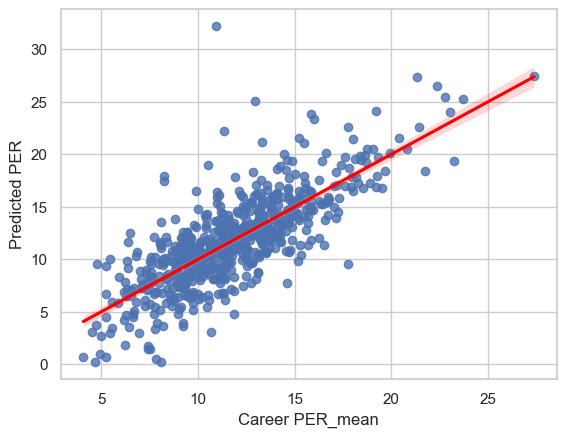

In [54]:
# plot of predicted PER against actual PER.
sns.regplot(x=reg.predict(train_x), y=train_y,line_kws={'color': 'red'})
plt.xlabel('Career PER_mean')
plt.ylabel('Predicted PER')

* Our model predicts well the average players, but underestimates the elite rookies and overestimates the worst

#### Let's evaluate our model by checking the test

In [55]:
# Add a constant term to the test features
test_x = sm.add_constant(test_x)
test_x = test_x.reset_index(drop=True)

# Predict using the fitted OLS model
predictions = reg.predict(test_x)

In [56]:

# Evaluate the model on the test set
r_squared = r2_score(test_y, predictions)


print(f'R-squared: {r_squared}')


R-squared: 0.5414086546380659


A R-squared value of 0.541 indicates that the model explains approximately 54% of the variance in the target variable on the test set. This is a reasonably good R-squared value, suggesting that the model captures a significant portion of the variability in the PER_mean variable.

### Let's make a prediction for rookies in 2023

In [57]:
rookies_df_2023 = rookies_2023_df.drop(columns = ["Player","Pos","Tm","Season","ID","WS","PER_mean"])
rookies_df_2023 = sm.add_constant(rookies_df_2023)
rookies_df_2023 = rookies_df_2023.reset_index(drop=True)
rookies_df_2023.head()

,const,Age,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,PER,WS/48
0,1.0,22,59,22,20.5,2.8,6.5,0.427,1.4,3.9,0.355,1.4,2.7,0.532,0.532,0.9,1.2,0.812,0.7,1.3,2.1,1.1,0.3,0.3,0.7,1.7,7.9,9.5,0.053
1,1.0,20,31,0,7.3,1.4,3.5,0.394,1.0,2.7,0.381,0.4,0.8,0.440,0.541,0.1,0.2,0.667,0.0,1.3,1.3,0.4,0.2,0.1,0.4,0.5,3.9,11.3,0.029
2,1.0,20,72,72,33.8,6.7,15.6,0.427,1.2,4.0,0.298,5.5,11.6,0.471,0.465,5.5,7.4,0.738,1.2,5.7,6.9,3.7,0.8,0.5,2.8,2.2,20.0,14.9,0.047
3,1.0,19,28,0,14.6,1.6,3.1,0.535,0.0,0.1,0.000,1.6,2.9,0.561,0.535,0.6,0.9,0.720,1.6,2.0,3.6,0.9,0.4,0.7,0.5,2.0,3.9,12.4,0.082
4,1.0,22,52,11,13.5,1.8,4.7,0.395,0.9,2.7,0.331,0.9,1.9,0.485,0.492,0.5,0.7,0.730,0.7,1.5,2.2,0.7,0.4,0.1,0.9,1.4,5.1,8.2,0.027


In [58]:
rookies_df_2023.shape

(79, 29)

In [59]:
# Predict using the fitted OLS model
predictions = reg.predict(rookies_df_2023)
rookies_2023_df['PER_pred'] = predictions.values.round(2)
rookies_2023_df.head()

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Season,ID,PER,WS,WS/48,PER_mean,PER_pred
1165,Ochai Agbaji,SG,22,UTA,59,22,20.5,2.8,6.5,0.427,1.4,3.9,0.355,1.4,2.7,0.532,0.532,0.9,1.2,0.812,0.7,1.3,2.1,1.1,0.3,0.3,0.7,1.7,7.9,2023,agbajoc01,9.5,1.3,0.053,9.5,10.96
1166,Patrick Baldwin Jr.,SF,20,GSW,31,0,7.3,1.4,3.5,0.394,1.0,2.7,0.381,0.4,0.8,0.440,0.541,0.1,0.2,0.667,0.0,1.3,1.3,0.4,0.2,0.1,0.4,0.5,3.9,2023,baldwpa01,11.3,0.1,0.029,11.3,11.07
1167,Paolo Banchero,PF,20,ORL,72,72,33.8,6.7,15.6,0.427,1.2,4.0,0.298,5.5,11.6,0.471,0.465,5.5,7.4,0.738,1.2,5.7,6.9,3.7,0.8,0.5,2.8,2.2,20.0,2023,banchpa01,14.9,2.4,0.047,14.9,19.30
1168,Dominick Barlow,PF,19,SAS,28,0,14.6,1.6,3.1,0.535,0.0,0.1,0.000,1.6,2.9,0.561,0.535,0.6,0.9,0.720,1.6,2.0,3.6,0.9,0.4,0.7,0.5,2.0,3.9,2023,barlodo01,12.4,0.7,0.082,12.4,13.87
1169,MarJon Beauchamp,SF,22,MIL,52,11,13.5,1.8,4.7,0.395,0.9,2.7,0.331,0.9,1.9,0.485,0.492,0.5,0.7,0.730,0.7,1.5,2.2,0.7,0.4,0.1,0.9,1.4,5.1,2023,beaucma01,8.2,0.4,0.027,8.2,9.73


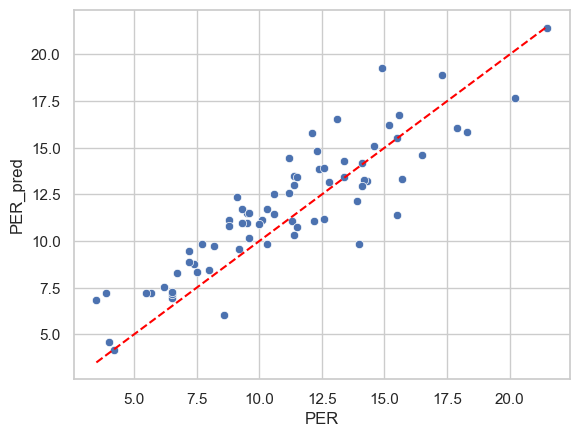

In [60]:
sns.scatterplot(x=rookies_2023_df["PER"],y=rookies_2023_df["PER_pred"])
plt.plot([rookies_2023_df["PER"].min(), rookies_2023_df["PER"].max()],
        [rookies_2023_df["PER"].min(), rookies_2023_df["PER"].max()],
        linestyle='--', color='red', label='Bisector')

The graph above shows how the model predicts who will stay on the same level and who is gonna increase or decrease his PER during the rest of his career.
Most of them, according to our model, will increase their PER

## 5. Clustering for a better regression model

We merge back together the rookies_df and the rookies_2023_df into cluster_df

In [61]:
rookies_2023_df.head(5)

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Season,ID,PER,WS,WS/48,PER_mean,PER_pred
1165,Ochai Agbaji,SG,22,UTA,59,22,20.5,2.8,6.5,0.427,1.4,3.9,0.355,1.4,2.7,0.532,0.532,0.9,1.2,0.812,0.7,1.3,2.1,1.1,0.3,0.3,0.7,1.7,7.9,2023,agbajoc01,9.5,1.3,0.053,9.5,10.96
1166,Patrick Baldwin Jr.,SF,20,GSW,31,0,7.3,1.4,3.5,0.394,1.0,2.7,0.381,0.4,0.8,0.440,0.541,0.1,0.2,0.667,0.0,1.3,1.3,0.4,0.2,0.1,0.4,0.5,3.9,2023,baldwpa01,11.3,0.1,0.029,11.3,11.07
1167,Paolo Banchero,PF,20,ORL,72,72,33.8,6.7,15.6,0.427,1.2,4.0,0.298,5.5,11.6,0.471,0.465,5.5,7.4,0.738,1.2,5.7,6.9,3.7,0.8,0.5,2.8,2.2,20.0,2023,banchpa01,14.9,2.4,0.047,14.9,19.30
1168,Dominick Barlow,PF,19,SAS,28,0,14.6,1.6,3.1,0.535,0.0,0.1,0.000,1.6,2.9,0.561,0.535,0.6,0.9,0.720,1.6,2.0,3.6,0.9,0.4,0.7,0.5,2.0,3.9,2023,barlodo01,12.4,0.7,0.082,12.4,13.87
1169,MarJon Beauchamp,SF,22,MIL,52,11,13.5,1.8,4.7,0.395,0.9,2.7,0.331,0.9,1.9,0.485,0.492,0.5,0.7,0.730,0.7,1.5,2.2,0.7,0.4,0.1,0.9,1.4,5.1,2023,beaucma01,8.2,0.4,0.027,8.2,9.73


In [62]:
cluster_df = pd.concat([rookies_df, rookies_2023_df.drop(["PER_pred"],axis=1)], ignore_index=True)

In [63]:
cluster_df.head(5)

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Season,ID,PER,WS,WS/48,PER_mean
0,David Andersen,C,29,HOU,63,0,14.1,2.3,5.4,0.432,0.4,1.2,0.346,1.9,4.2,0.458,0.472,0.7,1.1,0.687,0.9,2.4,3.3,0.7,0.2,0.2,0.6,1.9,5.8,2010,anderda03,12.1,1.3,0.070,11.50
1,Rodrigue Beaubois,PG,21,DAL,56,16,12.5,2.8,5.3,0.518,0.8,2.0,0.409,2.0,3.4,0.582,0.594,0.8,0.9,0.808,0.2,1.2,1.4,1.3,0.5,0.2,1.0,1.5,7.1,2010,beaubro01,18.5,2.0,0.134,13.95
2,DeJuan Blair,PF,20,SAS,82,23,18.2,3.4,6.0,0.556,0.0,0.0,0.000,3.4,6.0,0.558,0.556,1.1,2.0,0.547,2.4,4.0,6.4,0.8,0.6,0.5,1.4,2.7,7.8,2010,blairde01,17.7,4.6,0.147,13.91
3,Derrick Brown,SF,22,CHA,57,0,9.4,1.2,2.6,0.463,0.0,0.1,0.286,1.2,2.5,0.471,0.469,0.8,1.3,0.667,0.5,0.8,1.4,0.3,0.4,0.2,0.3,0.9,3.3,2010,brownde04,12.6,1.3,0.114,13.40
4,Chase Budinger,SF,21,HOU,74,4,20.1,3.4,7.6,0.441,1.2,3.4,0.369,2.1,4.3,0.497,0.522,0.9,1.2,0.770,0.5,2.5,3.0,1.2,0.5,0.1,0.6,1.1,8.9,2010,budinch01,14.1,3.1,0.100,12.63


We will use the kmeans algorithm to divide the players in clusters depending from the values of their basic statistics: Points per game, Assists per game and Total rebounds per game

  File "c:\Users\ricca\AppData\Local\Programs\Python\Python311\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


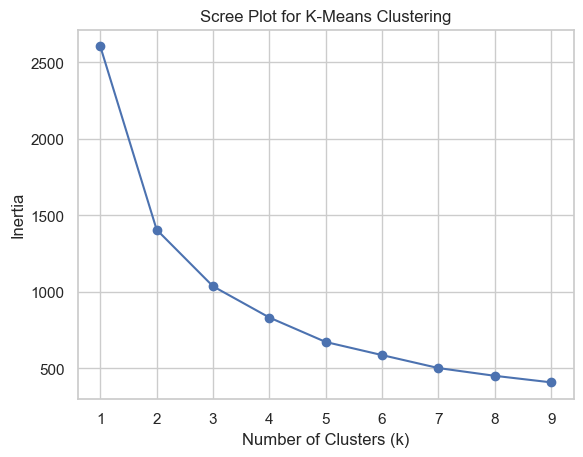

In [64]:
features = cluster_df[['TRB', 'AST', 'PTS']]
  
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

k_values = range(1, 10)  # You can adjust the range based on your data and requirements

# Calculate the inertia for each k
inertia_values = []
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features_scaled)
    inertia_values.append(kmeans.inertia_)

# Plot the scree plot
plt.plot(k_values, inertia_values, marker='o')
plt.title('Scree Plot for K-Means Clustering')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.show()


From the Scree plot above we decide to use a k=3 number of clusters

In [65]:
num_clusters = 3

kmeans = KMeans(n_clusters=num_clusters, random_state=42)
cluster_df['cluster'] = kmeans.fit_predict(features_scaled)+1

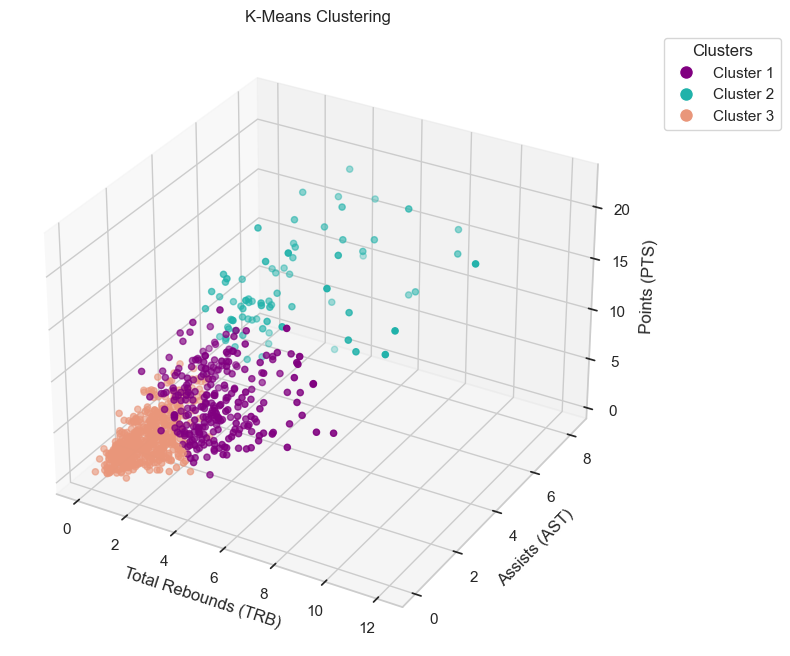

In [66]:
colors = {1: 'Purple', 2: 'LightSeaGreen', 3: 'DarkSalmon'}

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection="3d")

scatter = ax.scatter(cluster_df["TRB"], cluster_df["AST"], cluster_df["PTS"], c=cluster_df["cluster"].map(colors))

ax.set_title("K-Means Clustering")
ax.set_xlabel("Total Rebounds (TRB)")
ax.set_ylabel("Assists (AST)")
ax.set_zlabel("Points (PTS)")


# Create custom legend entries
legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=f'Cluster {cluster}') for cluster, color in colors.items()]

# Adding a legend
ax.legend(handles=legend_elements, title="Clusters", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

In [67]:
cluster_1=cluster_df[cluster_df["cluster"]==1]
np.round(cluster_1[["PTS","AST","TRB"]].describe().loc[['mean', 'min','max']],2)


,PTS,AST,TRB
mean,8.11,1.38,4.01
min,2.30,0.00,1.50
max,17.50,3.70,8.90


In [68]:
cluster_2=cluster_df[cluster_df["cluster"]==2]
np.round(cluster_2[["PTS","AST","TRB"]].describe().loc[['mean', 'min','max']],2)

,PTS,AST,TRB
mean,13.79,4.39,4.39
min,3.00,1.80,1.60
max,22.50,8.30,12.10


In [69]:
cluster_3=cluster_df[cluster_df["cluster"]==3]
np.round(cluster_3[["PTS","AST","TRB"]].describe().loc[['mean', 'min','max']],2)

,PTS,AST,TRB
mean,3.54,0.86,1.58
min,0.50,0.00,0.00
max,8.00,3.80,3.60


In [70]:
len(cluster_1),len(cluster_2),len(cluster_3)

(263, 79, 526)

## 6. Regression models on the clusters

### "Average" Players

In [71]:
A_rook=cluster_1[cluster_1['Season']!=2023]
A_rook=A_rook.drop(["Player","Pos","Tm","Season","ID","WS","PER_mean","cluster"],axis=1)
A_rook=sm.add_constant(A_rook)
A_rook=A_rook.reset_index(drop=True)

Y_a=cluster_1.loc[cluster_1['Season'] != 2023, 'PER_mean']
Y_a=Y_a.reset_index(drop=True)

In [72]:
reg_a=sm.OLS(Y_a,A_rook).fit()
print(reg_a.summary())

                            OLS Regression Results                            
Dep. Variable:               PER_mean   R-squared:                       0.551
Model:                            OLS   Adj. R-squared:                  0.491
Method:                 Least Squares   F-statistic:                     9.235
Date:                Sun, 17 Dec 2023   Prob (F-statistic):           7.76e-24
Time:                        12:50:30   Log-Likelihood:                -565.49
No. Observations:                 240   AIC:                             1189.
Df Residuals:                     211   BIC:                             1290.
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         16.7933      7.956      2.111      0.0

<Axes: ylabel='PER_mean'>

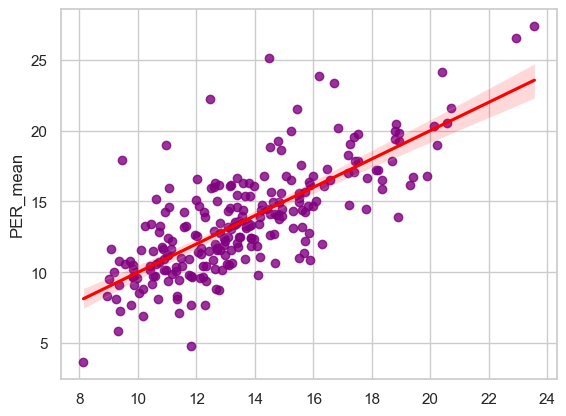

In [73]:
sns.regplot(x=reg_a.predict(A_rook), y=Y_a,line_kws={'color': 'red'},scatter_kws={"color":'purple'})

### "Top" Players

In [74]:
T_rook=cluster_2[cluster_2['Season']!=2023]
T_rook=T_rook.drop(["Player","Pos","Tm","Season","ID","WS","PER_mean","cluster"],axis=1)
T_rook=sm.add_constant(T_rook)
T_rook=T_rook.reset_index(drop=True)

Y_t=cluster_2.loc[cluster_2['Season'] != 2023, 'PER_mean']
Y_t=Y_t.reset_index(drop=True)

In [75]:
reg_t=sm.OLS(Y_t,T_rook).fit()
print(reg_t.summary())

                            OLS Regression Results                            
Dep. Variable:               PER_mean   R-squared:                       0.820
Model:                            OLS   Adj. R-squared:                  0.705
Method:                 Least Squares   F-statistic:                     7.155
Date:                Sun, 17 Dec 2023   Prob (F-statistic):           5.31e-09
Time:                        12:50:36   Log-Likelihood:                -145.24
No. Observations:                  73   AIC:                             348.5
Df Residuals:                      44   BIC:                             414.9
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         29.3615     16.823      1.745      0.0

<Axes: ylabel='PER_mean'>

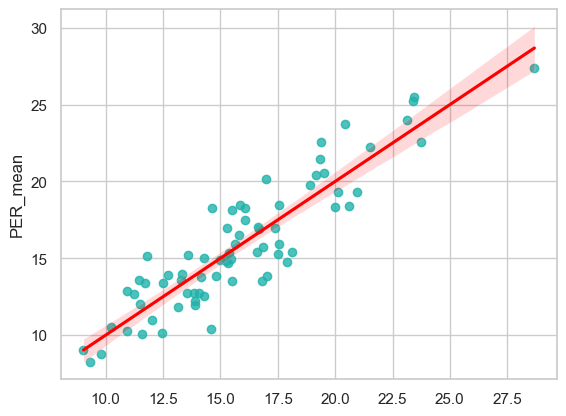

In [76]:
sns.regplot(x=reg_t.predict(T_rook), y=Y_t,line_kws={'color': 'red'},scatter_kws={"color":'LightSeaGreen'})

### "Worse" Players

In [77]:
W_rook=cluster_3[cluster_3['Season']!=2023]
W_rook=W_rook.drop(["Player","Pos","Tm","Season","ID","WS","PER_mean","cluster"],axis=1)
W_rook=sm.add_constant(W_rook)
W_rook=W_rook.reset_index(drop=True)

Y_w=cluster_3.loc[cluster_3['Season'] != 2023, 'PER_mean']
Y_w=Y_w.reset_index(drop=True)

In [78]:
reg_w=sm.OLS(Y_w,W_rook).fit()
print(reg_w.summary())

                            OLS Regression Results                            
Dep. Variable:               PER_mean   R-squared:                       0.463
Model:                            OLS   Adj. R-squared:                  0.429
Method:                 Least Squares   F-statistic:                     13.75
Date:                Sun, 17 Dec 2023   Prob (F-statistic):           1.95e-44
Time:                        12:50:43   Log-Likelihood:                -1158.7
No. Observations:                 476   AIC:                             2375.
Df Residuals:                     447   BIC:                             2496.
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.8389      2.633      2.597      0.0

<Axes: ylabel='PER_mean'>

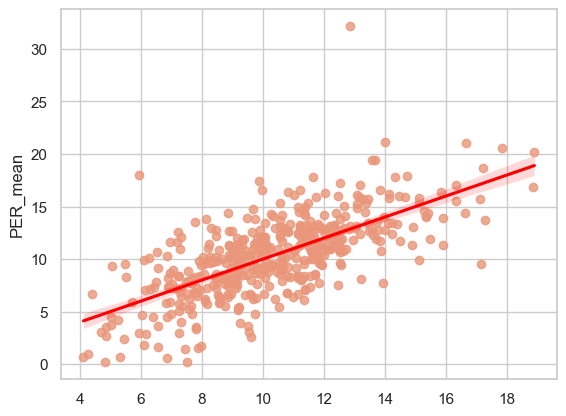

In [79]:
sns.regplot(x=reg_w.predict(W_rook), y=Y_w,line_kws={'color': 'red'},scatter_kws={"color":"DarkSalmon"})

## 7. New Predictions

#### CLUSTER 1

In [80]:
rookies_cluster1=cluster_1[cluster_1['Season']==2023]
rookies_cluster1=rookies_cluster1.drop(["Player","Pos","Tm","Season","ID","WS","PER_mean","cluster"],axis=1)
rookies_cluster1 = sm.add_constant(rookies_cluster1)
rookies_cluster1 = rookies_cluster1.reset_index(drop=True)

In [81]:
rkcl1=rookies_2023_df.merge(cluster_1.loc[cluster_1['Season'] == 2023, ['ID']], on='ID')

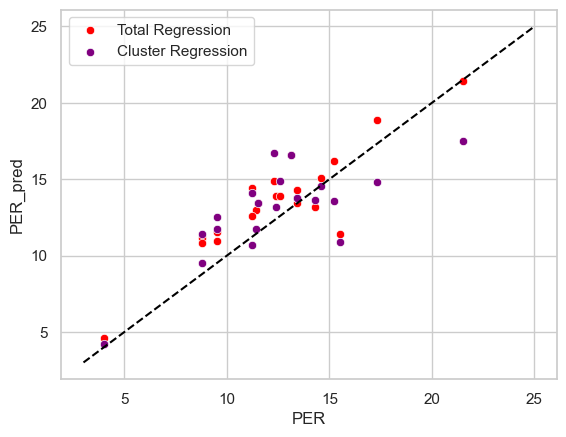

In [82]:
sns.scatterplot(x=rkcl1["PER"], y=rkcl1["PER_pred"], label="Total Regression",color='red')
sns.scatterplot(x=rookies_cluster1["PER"],y=reg_w.predict(rookies_cluster1),label="Cluster Regression",color="Purple")

plt.plot([3, 25],[3, 25],linestyle='--', color='black', label='Bisector')
plt.show()

#### CLUSTER 2

In [83]:
rookies_cluster2=cluster_2[cluster_2['Season']==2023]
rookies_cluster2=rookies_cluster2.drop(["Player","Pos","Tm","Season","ID","WS","PER_mean","cluster"],axis=1)
rookies_cluster2 = sm.add_constant(rookies_cluster2)
rookies_cluster2 = rookies_cluster2.reset_index(drop=True)

In [84]:
rkcl2=rookies_2023_df.merge(cluster_2.loc[cluster_2['Season'] == 2023, ['ID']], on='ID')

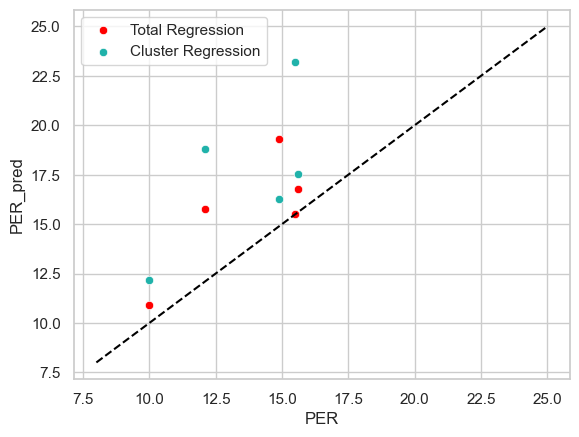

In [85]:
sns.scatterplot(x=rkcl2["PER"], y=rkcl2["PER_pred"], label="Total Regression",color='red')
sns.scatterplot(x=rookies_cluster2["PER"],y=reg_t.predict(rookies_cluster2),label="Cluster Regression",color='LightSeaGreen')

plt.plot([8, 25],[8, 25],linestyle='--', color='black', label='Bisector')
plt.show()

#### CLUSTER 3

In [86]:
rookies_cluster3 = cluster_3[cluster_3['Season']==2023]
rookies_cluster3 = rookies_cluster3.drop(["Player","Pos","Tm","Season","ID","WS","PER_mean","cluster"],axis=1)
rookies_cluster3 = sm.add_constant(rookies_cluster3)
rookies_cluster3 = rookies_cluster3.reset_index(drop=True)

In [87]:
rkcl3=rookies_2023_df.merge(cluster_3.loc[cluster_3['Season'] == 2023, ['ID']], on='ID')

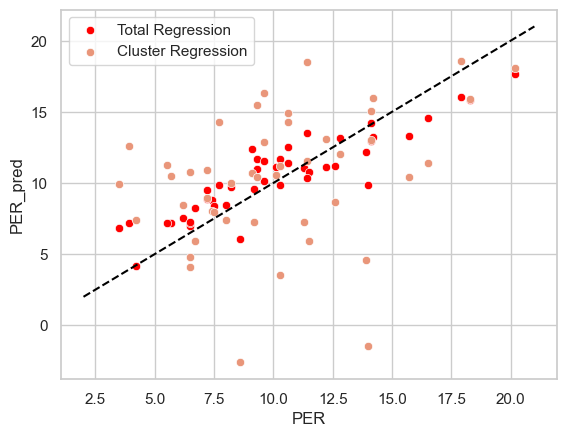

In [88]:
sns.scatterplot(x=rkcl3["PER"], y=rkcl3["PER_pred"], label="Total Regression",color='red')
sns.scatterplot(x=rookies_cluster3["PER"],y=reg_t.predict(rookies_cluster3),label="Cluster Regression",color="DarkSalmon")

plt.plot([2, 21],[2, 21],linestyle='--', color='black', label='Bisector')
plt.show()